# Purpose
- Gather calcium and spike data
- z-scoring
- Match with frame_whisker_behavior dataset
- Calculate touch response per trial (before and after decision lick)
- Per neuron activity pattern change across training
- Population activity pattern change across training
- Focus on 2-angle training sessions only

<br>
Continued from 220924_final_signal_extraction.ipynb & 221024_build_dataset.ipynb

In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import os, glob, h5py
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import notebook
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl

h5_dir_1 = Path('H:/')
h5_dir_2 = Path('F:/')
b_dir = Path('D:/SoloData/')
w_dir = Path('D:/WhiskerVideo/')
mice =          [25,    27,   30,   36,     37,     38,     39,     41,     52,     53,     54,     56]
expert_mice = [25, 27, 30, 36, 39, 52]
ref_sessions = [4,3,3,1,1,3]
exp_sessions = [19,10,21,17,23,21]
# refSessions =   [4,     3,    3,    1,      7,      2,      1,      3,      3,      3,      3,      3]
# expSessions =   [19,    10,   21,   17,     0,      0,      23,     0,      21,     0,      0,      0]
# zoom =          [2,     2,    2,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7]
image_rate_list = [30.8359, 30.8359, 30.8359, 30.8359, 
                    24.2892, 24.2892, 24.2892, 24.2892,
                    30.8359, 30.8359, 30.8359, 30.8359] # from .mat file (sbx)
image_size_list = [[512,796], [512,796], [512,796], [512,796], 
                    [650,796], [650,796], [650,796], [650,796], 
                    [512,796], [512,796], [512,796], [512,796]] # from .mat file (sbx)
planes = range(1,9)

import socket
hostname = socket.gethostname()
if hostname == 'HNB228-LABPC6':
    save_dir_base = Path(r'C:\Users\shires\Dropbox\Works\Projects\2020 Neural stretching in S1\Results')
else:
    save_dir_base = Path('C:/Users/jinho.kim/Dropbox/Works/Projects/2020 Neural stretching in S1/Results')

In [26]:
emi = 0
plane = 1

mouse = expert_mice[emi]
if emi < 3:
    h5_dir = h5_dir_1
else:
    h5_dir = h5_dir_2

plane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
sts_reg = np.load(plane_dir / f'JK{mouse:03d}_plane{plane}_session_to_session_registration.npy', allow_pickle=True).item()
session_nums = sts_reg['selected_session_num']
# This info is valid in pi:pi+4

# for session_num in session_nums:
#     if session_num > 900:
#         wb_snum = session_num // 10 + session_num % 900 # pre1 is 901 in calcium but 91 in behavior and whisker
#     else:
#         wb_snum = session_num

In [5]:
sts_reg.keys()

dict_keys(['mouse', 'plane', 'edge_buffer', 'selected_session_i', 'selected_session_num', 'zdrift_list', 'registration_method', 'bilinear_result', 'affine_result', 'suite2p_result', 'old_result'])

In [12]:
len(sts_reg['selected_session_num'])

13

In [6]:
roi_collection_fn = f'JK{mouse:03d}_plane{plane}_roi_collection_filtered.npy'
roi_collection = np.load(plane_dir / roi_collection_fn, allow_pickle=True).item()
roi_collection.keys()

dict_keys(['final_master_map_sessions', 'final_viable_cell_index_list', 'final_matching_master_roi_index_list', 'filtered_matching_master_roi_index_list'])

In [24]:
# Total ROIs in each session
# - some might be 'not cell': look up iscell.npy
[rcmap.shape for rcmap in roi_collection['final_master_map_sessions']]

[(155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627),
 (155, 327, 627)]

In [22]:
# Index of filtered master map ROI, corresponding to each ROI in equal_lam (session-curated ROI)
# Index matches to the index of 'iscell' ROIs in each session equal_lam
# Length indicates # of such ROIs in each session
[len(rc) for rc in roi_collection['filtered_matching_master_roi_index_list']]

[58, 59, 66, 60, 47, 65, 51, 53, 25, 52, 50, 64, 63]

In [28]:
session_nums

array([ 1,  2,  3,  4,  5,  6, 13, 15, 17, 19, 22, 23, 24])

In [333]:
si = 0
session_num = session_nums[si]
session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
iscell = np.load(session_roi_dir / 'iscell.npy', allow_pickle=True)[:,0] # Same for all sessions in a plane
events = np.load(session_roi_dir / 'spks.npy', allow_pickle=True).transpose() # To make each cell in each column, and column-direction matches with whisker-behavior dataFrame.
events_zscore = (events - np.mean(events, axis=0)) / np.std(events, axis=0)
print(f'Session {session_num:02d}')
print(events.shape)
print(len(np.where(iscell==1)[0]))
events.shape[1] == len(iscell)

Session 01
(5006, 155)
155


True

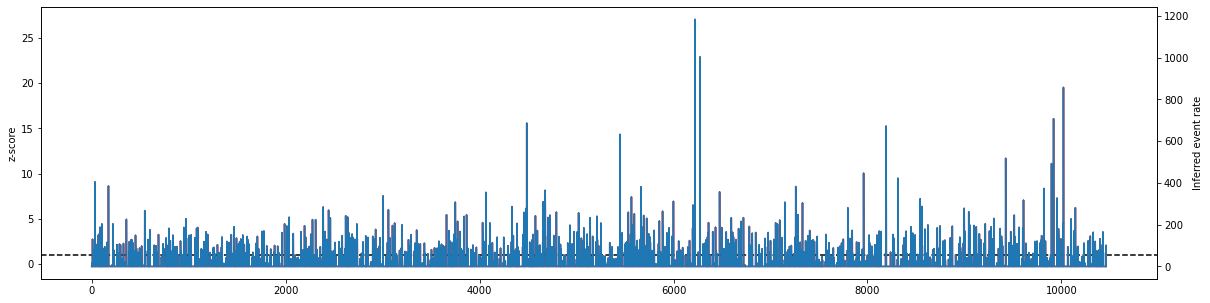

In [180]:
# Single neuron test
ci = 150
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(events_zscore[:,ci], 'r')
ax.set_ylabel('z-score')
ax2 = ax.twinx()
ax2.plot(events[:,ci])
ax2.set_ylabel('Inferred event rate')
ax.axhline(1, color='k', linestyle='--')

In [330]:
# Plot events and z-scores across sessions
# Select regular training sessions only (for now)
si = 1
session_num = session_nums[si]
wb_df = pd.read_pickle(plane_dir / f'JK{mouse:03d}_S{session_num:02d}_plane{plane}_frame_whisker_behavior.pkl')
np.sort(wb_df.keys())

array(['answer_lick_frame', 'answer_lick_left', 'answer_lick_right',
       'answer_period_frame', 'arc_length_onset', 'correct',
       'delta_kappaH', 'delta_kappaV', 'delta_phi', 'delta_theta',
       'distractor', 'first_reward_lick_frame', 'first_reward_lick_left',
       'first_reward_lick_right', 'frame_end_time', 'frame_index',
       'frame_start_time', 'kappaH_onset', 'kappaV_onset', 'miss',
       'mouse_name', 'num_lick_left', 'num_lick_right', 'phi_onset',
       'pole_angle', 'pole_ap_distance', 'pole_moving_frame',
       'pole_radial_distance', 'pole_up_frame',
       'post_answer_pole_up_frame', 'pre_answer_pole_up_frame',
       'session_name', 'session_type', 'slide_distance', 'task_target',
       'theta_onset', 'touch_count', 'touch_duration', 'trialNum',
       'trial_duration', 'trial_type', 'wrong'], dtype=object)

In [384]:
# Function calculating correct rate
def calculate_correct_rate(wb_df):
    temp_df = wb_df.drop_duplicates('trialNum')[['trialNum','correct','wrong','miss']]
    num_trials = len(temp_df)
    num_correct = temp_df.correct.sum()
    num_wrong = temp_df.wrong.sum()
    num_miss = temp_df.miss.sum()
    num_answer = num_correct + num_wrong
    assert num_correct + num_wrong + num_miss == num_trials
    answer_rate = 1 - num_miss / num_trials
    correct_rate = num_correct / num_trials
    return correct_rate, num_answer, answer_rate

# Single plane single session test

In [703]:
mouse = 27
session_num = 15
plane = 5
plane_dir = h5_dir / f'{mouse:03d}'/ f'plane_{plane}'
wb_df = pd.read_pickle(plane_dir / f'JK{mouse:03d}_S{session_num:02d}_plane{plane}_frame_whisker_behavior.pkl')

In [704]:
wb_df

,trialNum,frame_start_time,frame_end_time,trial_duration,frame_index,kappaH_onset,kappaV_onset,phi_onset,theta_onset,arc_length_onset,...,first_reward_lick_right,correct,wrong,miss,trial_type,task_target,distractor,mouse_name,session_name,session_type
0,52,0.216557,0.248987,5.580891,0,NaN,NaN,NaN,NaN,NaN,...,False,True,False,False,rn,Angle,Off,JK027,S15,2port-Discrim
1,52,0.346276,0.378706,5.580891,1,NaN,NaN,NaN,NaN,NaN,...,False,True,False,False,rn,Angle,Off,JK027,S15,2port-Discrim
2,52,0.475995,0.508425,5.580891,2,NaN,NaN,NaN,NaN,NaN,...,False,True,False,False,rn,Angle,Off,JK027,S15,2port-Discrim
3,52,0.605714,0.638144,5.580891,3,NaN,NaN,NaN,NaN,NaN,...,False,True,False,False,rn,Angle,Off,JK027,S15,2port-Discrim
4,52,0.735433,0.767863,5.580891,4,NaN,NaN,NaN,NaN,NaN,...,False,True,False,False,rn,Angle,Off,JK027,S15,2port-Discrim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8199,463,5.538834,5.571263,6.098627,8199,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,ln,Angle,Off,JK027,S15,2port-Discrim
8200,463,5.668553,5.700982,6.098627,8200,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,ln,Angle,Off,JK027,S15,2port-Discrim
8201,463,5.798272,5.830701,6.098627,8201,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,ln,Angle,Off,JK027,S15,2port-Discrim
8202,463,5.927990,5.960420,6.098627,8202,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,ln,Angle,Off,JK027,S15,2port-Discrim


In [513]:
# Per trial touch response
# Pre-answer (including the answer lick frame) and post-answer (starting AFTER the answer lick frame)
# Response amplitue (in terms of z-score)
# Divided by the total # of touches within the window
# Responsiveness, tested by t-test to the values before pole up (up until the first pole moving or pole up frame, whichever is faster)
emi = 2
plane = 1

mouse = expert_mice[emi]
if emi < 3:
    h5_dir = h5_dir_1
else:
    h5_dir = h5_dir_2

plane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
sts_reg = np.load(plane_dir / f'JK{mouse:03d}_plane{plane}_session_to_session_registration.npy', allow_pickle=True).item()
session_nums = sts_reg['selected_session_num']

si = 9
session_num = session_nums[si]
session_plane_info = f'JK{mouse:03d} S{session_num:02d} plane{plane}'

# Load events
session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
iscell = np.load(session_roi_dir / 'iscell.npy', allow_pickle=True)[:,0] # Same for all sessions in a plane
events = np.load(session_roi_dir / 'spks.npy', allow_pickle=True).transpose() # To make each cell in each column, and column-direction matches with whisker-behavior dataFrame.
events_zscore = (events - np.mean(events, axis=0)) / np.std(events, axis=0)
print(f'Session {session_num:02d}')
print(events.shape)
print(len(np.where(iscell==1)[0]))
events.shape[1] == len(iscell)


events = events[:,np.where(iscell)[0]]
events_zscore = events_zscore[:,np.where(iscell)[0]]

# load whisker-behavior dataFrame
wb_df = pd.read_pickle(plane_dir / f'JK{mouse:03d}_S{session_num:02d}_plane{plane}_frame_whisker_behavior.pkl')

trial_start_buffer_frame = 3 # to prevent abrupt increase of signal by laser on after ITI and possible contamination by trial start cue
trial_nums = wb_df.trialNum.unique()
pre_pole_activity = np.empty((len(trial_nums), events_zscore.shape[1]))
pre_pole_activity[:] = np.nan
pre_answer_response = np.empty((len(trial_nums), events_zscore.shape[1]))
pre_answer_response[:] = np.nan
post_answer_response = np.empty((len(trial_nums), events_zscore.shape[1]))
post_answer_response[:] = np.nan
post_pole_activity = np.empty((len(trial_nums), events_zscore.shape[1]))
post_pole_activity[:] = np.nan
pre_pole_length = np.zeros(len(trial_nums))

for ti, trial_num in enumerate(trial_nums):
    trial_wb_df = wb_df[wb_df.trialNum == trial_num]
    if (not trial_wb_df.iloc[0].miss) and (np.nansum(trial_wb_df.touch_count.values) > 0): # only when there was an answer and at least one touch
        trial_events_zscore = events_zscore[np.where(wb_df.trialNum == trial_num)[0],:]
        if len(np.where(trial_wb_df.pole_moving_frame.values)[0]) > 0:
            first_pole_moving_ind = min(np.where(trial_wb_df.pole_up_frame.values)[0][0], np.where(trial_wb_df.pole_moving_frame.values)[0][0])
        else:
            first_pole_moving_ind = np.where(trial_wb_df.pole_up_frame.values)[0][0]
        pre_pole_inds = range(trial_start_buffer_frame,first_pole_moving_ind)
        pre_pole_length[ti] = len(pre_pole_inds)
        pre_answer_pole_inds = range(np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][0], np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][-1] +2)
        pre_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[pre_answer_pole_inds])

        post_answer_pole_inds = np.where(trial_wb_df.post_answer_pole_up_frame.values)[0] # last frame should be included
        post_pole_inds = []
        if len(post_answer_pole_inds) > 0:
            assert post_answer_pole_inds[0] - pre_answer_pole_inds[-1] == 1
            post_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[post_answer_pole_inds])
            if len(trial_wb_df) > post_answer_pole_inds[-1]:
                post_pole_inds = range(post_answer_pole_inds[-1]+1, len(trial_wb_df))
        else:
            post_answer_num_touch = 0
        
        assert len(np.intersect1d(pre_pole_inds, pre_answer_pole_inds))==0
        assert len(np.intersect1d(pre_answer_pole_inds, post_answer_pole_inds))==0
        
        pre_pole_activity[ti,:] = np.mean(trial_events_zscore[pre_pole_inds, :], axis=0)
        if pre_answer_num_touch > 0:
            pre_answer_response[ti,:] = np.mean(trial_events_zscore[pre_answer_pole_inds,:], axis=0) / pre_answer_num_touch
        if post_answer_num_touch > 0:
            post_answer_response[ti,:] = np.mean(trial_events_zscore[post_answer_pole_inds,:], axis=0) / post_answer_num_touch
        if len(post_pole_inds) > 0:
            post_pole_activity[ti,:] = np.mean(trial_events_zscore[post_pole_inds, :], axis=0)



Session 22
(6479, 172)
171


In [514]:
wb_df.keys()

Index(['trialNum', 'frame_start_time', 'frame_end_time', 'trial_duration',
       'frame_index', 'kappaH_onset', 'kappaV_onset', 'phi_onset',
       'theta_onset', 'arc_length_onset', 'touch_count', 'delta_kappaH',
       'delta_kappaV', 'delta_phi', 'delta_theta', 'slide_distance',
       'touch_duration', 'pole_up_frame', 'pole_moving_frame', 'pole_angle',
       'pole_ap_distance', 'pole_radial_distance', 'num_lick_left',
       'num_lick_right', 'answer_lick_frame', 'answer_lick_left',
       'answer_lick_right', 'pre_answer_pole_up_frame', 'answer_period_frame',
       'post_answer_pole_up_frame', 'first_reward_lick_frame',
       'first_reward_lick_left', 'first_reward_lick_right', 'correct', 'wrong',
       'miss', 'trial_type', 'task_target', 'distractor', 'mouse_name',
       'session_name', 'session_type'],
      dtype='object')

In [518]:
wb_df.session_type.values[0]

'2port-Discrim'

In [336]:
print(np.mean(pre_pole_length))
print(np.std(pre_pole_length))

2.7333333333333334
2.3879326251429758


In [392]:
# Calculating p-values
pvalue_pre_answer_response = stats.ttest_1samp(pre_answer_response - pre_pole_activity, 0, nan_policy='omit')[1].data
pvalue_post_answer_response = stats.ttest_1samp(post_answer_response - pre_pole_activity, 0, nan_policy='omit')[1].data
pvalue_post_pre_answer = stats.ttest_1samp(post_answer_response - pre_answer_response, 0, nan_policy='omit')[1].data

56
0


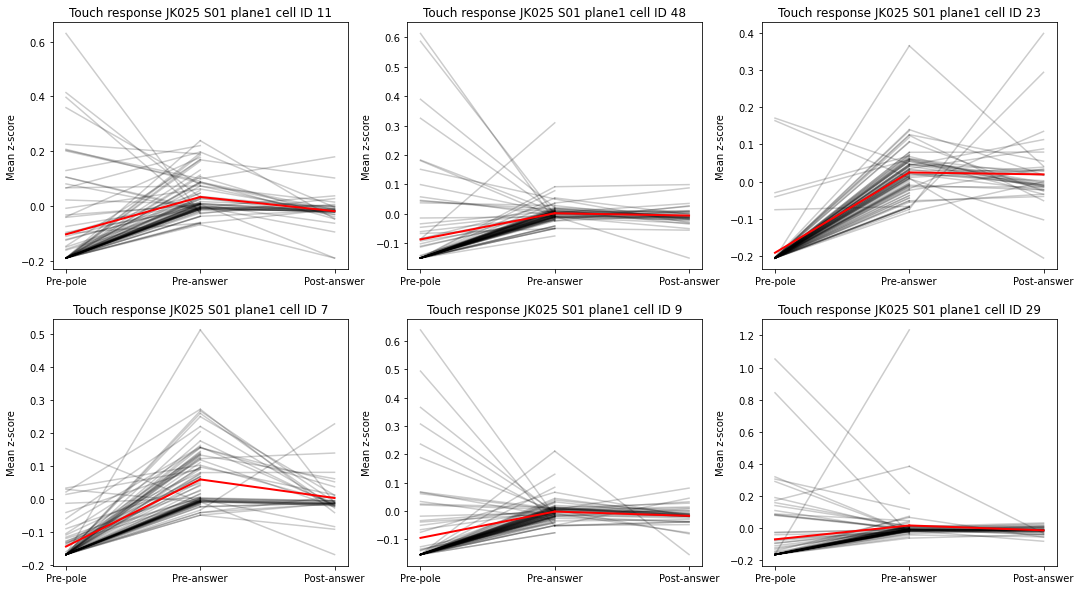

In [393]:
# Test the p-value by plotting individual cell
p001_pre_answer_ind = np.where(pvalue_pre_answer_response<0.001)[0]
print(len(p001_pre_answer_ind))
negative_response_ind = np.where(np.nanmean(pre_answer_response, axis=0) - np.nanmean(pre_pole_activity, axis=0) < 0)[0]
print(len(np.intersect1d(negative_response_ind, p001_pre_answer_ind)))
rand_inds = np.random.choice(p001_pre_answer_ind,6)
fig, ax = plt.subplots(2,3,figsize=(18,10))
for i, ind in enumerate(rand_inds):
    iy = i // 3
    ix = i % 3
    for ii in range(pre_pole_activity.shape[0]):
        ax[iy,ix].plot([1,2], [pre_pole_activity[ii,ind], pre_answer_response[ii,ind]], 'k-', alpha=0.2)
        ax[iy,ix].plot([2,3], [pre_answer_response[ii,ind], post_answer_response[ii,ind]], 'k-', alpha=0.2)
    ax[iy,ix].plot([1,2], [np.nanmean(pre_pole_activity[:,ind]), np.nanmean(pre_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].plot([2,3], [np.nanmean(pre_answer_response[:,ind]), np.nanmean(post_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].set_xticks([1,2,3])
    ax[iy,ix].set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
    ax[iy,ix].set_ylabel('Mean z-score')
    ax[iy,ix].set_title(f'Touch response {session_plane_info} cell ID {ind}')


Text(0.5, 1.0, 'JK025 S01 plane1: All cells\nmean=-0.2527 p=2.0847e-36')

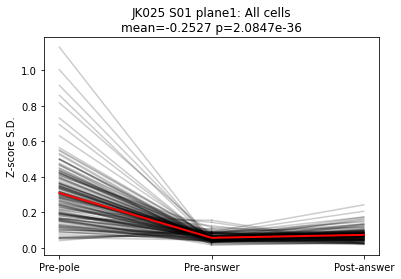

In [394]:
# Reduced variability?
p_std_change = stats.ttest_1samp(np.nanstd(pre_answer_response, axis=0) - np.nanstd(pre_pole_activity, axis=0), 0).pvalue
mean_std_change = np.mean(np.nanstd(pre_answer_response, axis=0) - np.nanstd(pre_pole_activity, axis=0))
fig, ax = plt.subplots()
pre_answer_std = np.nanstd(pre_answer_response, axis=0)
pre_pole_std = np.nanstd(pre_pole_activity, axis=0)
post_answer_std = np.nanstd(post_answer_response, axis=0)
for ii in range(pre_answer_response.shape[0]):
    ax.plot([1,2], [pre_pole_std[ii], pre_answer_std[ii]], 'k-', alpha=0.2)
ax.plot([1,2], [np.mean(pre_pole_std), np.mean(pre_answer_std)], 'r-', linewidth=2)
for ii in range(pre_answer_response.shape[0]):
    ax.plot([2,3], [pre_answer_std[ii], post_answer_std[ii]], 'k-', alpha=0.2)
ax.plot([2,3], [np.mean(pre_answer_std), np.mean(post_answer_std)], 'r-', linewidth=2)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
ax.set_ylabel('Z-score S.D.')
ax.set_title(f'{session_plane_info}: All cells\nmean={mean_std_change:.4f} p={p_std_change:.4e}')

Text(0.5, 1.0, 'JK025 S01 plane1 Pre-answer - pre-pole; p < 0.001\nmean=-0.0929 p=3.0520e-13')

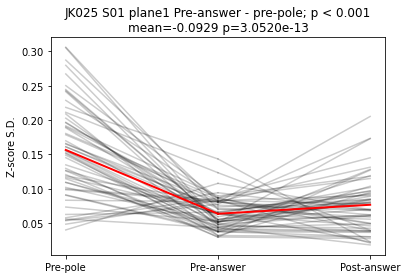

In [395]:
# What about p<0.001 cells?
p_std_change = stats.ttest_1samp(np.nanstd(pre_answer_response[:,p001_pre_answer_ind], axis=0) - np.nanstd(pre_pole_activity[:,p001_pre_answer_ind], axis=0), 0).pvalue
mean_std_change = np.mean(np.nanstd(pre_answer_response[:,p001_pre_answer_ind], axis=0) - np.nanstd(pre_pole_activity[:,p001_pre_answer_ind], axis=0))

fig, ax = plt.subplots()
pre_answer_std = np.nanstd(pre_answer_response[:,p001_pre_answer_ind], axis=0)
pre_pole_std = np.nanstd(pre_pole_activity[:,p001_pre_answer_ind], axis=0)
post_answer_std = np.nanstd(post_answer_response[:,p001_pre_answer_ind], axis=0)
for ii in range(len(p001_pre_answer_ind)):
    ax.plot([1,2], [pre_pole_std[ii], pre_answer_std[ii]], 'k-', alpha=0.2)
ax.plot([1,2], [np.mean(pre_pole_std), np.mean(pre_answer_std)], 'r-', linewidth=2)
for ii in range(len(p001_pre_answer_ind)):
    ax.plot([2,3], [pre_answer_std[ii], post_answer_std[ii]], 'k-', alpha=0.2)
ax.plot([2,3], [np.mean(pre_answer_std), np.mean(post_answer_std)], 'r-', linewidth=2)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
ax.set_ylabel('Z-score S.D.')
ax.set_title(f'{session_plane_info} Pre-answer - pre-pole; p < 0.001\nmean={mean_std_change:.4f} p={p_std_change:.4e}')

20
0


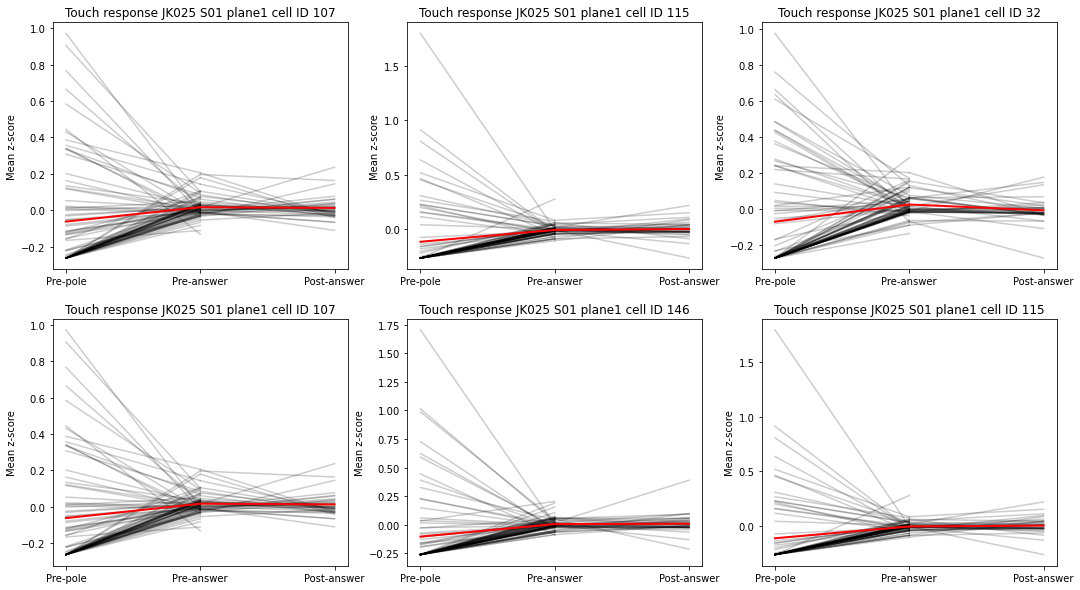

In [378]:
# 0.001 <= p < 0.01
p01_pre_answer_ind = np.setdiff1d(np.where(pvalue_pre_answer_response<0.01)[0], np.where(pvalue_pre_answer_response<0.001)[0])
print(len(p01_pre_answer_ind))
negative_response_ind = np.where(np.nanmean(pre_answer_response, axis=0) - np.nanmean(pre_pole_activity, axis=0) < 0)[0]
print(len(np.intersect1d(negative_response_ind, p01_pre_answer_ind)))
rand_inds = np.random.choice(p01_pre_answer_ind,6)
fig, ax = plt.subplots(2,3,figsize=(18,10))
for i, ind in enumerate(rand_inds):
    iy = i // 3
    ix = i % 3
    for ii in range(pre_pole_activity.shape[0]):
        ax[iy,ix].plot([1,2], [pre_pole_activity[ii,ind], pre_answer_response[ii,ind]], 'k-', alpha=0.2)
        ax[iy,ix].plot([2,3], [pre_answer_response[ii,ind], post_answer_response[ii,ind]], 'k-', alpha=0.2)
    ax[iy,ix].plot([1,2], [np.nanmean(pre_pole_activity[:,ind]), np.nanmean(pre_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].plot([2,3], [np.nanmean(pre_answer_response[:,ind]), np.nanmean(post_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].set_xticks([1,2,3])
    ax[iy,ix].set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
    ax[iy,ix].set_ylabel('Mean z-score')
    ax[iy,ix].set_title(f'Touch response {session_plane_info} cell ID {ind}')

15
0


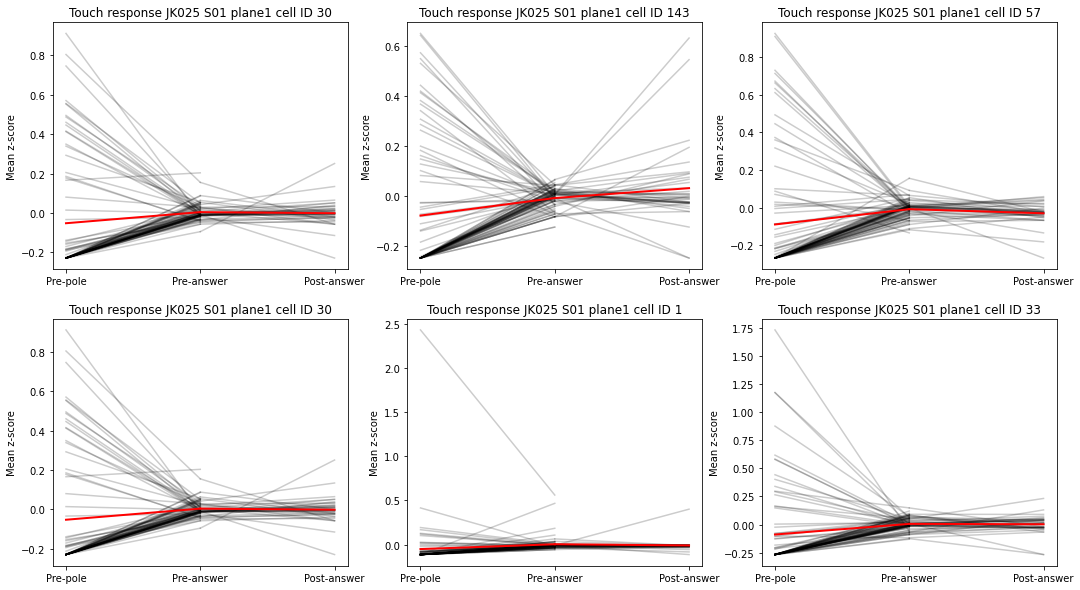

In [379]:
# 0.01 <= p < 0.05
p05_pre_answer_ind = np.setdiff1d(np.where(pvalue_pre_answer_response<0.05)[0], np.where(pvalue_pre_answer_response<0.01)[0])
print(len(p05_pre_answer_ind))
negative_response_ind = np.where(np.nanmean(pre_answer_response, axis=0) - np.nanmean(pre_pole_activity, axis=0) < 0)[0]
print(len(np.intersect1d(negative_response_ind, p05_pre_answer_ind)))
rand_inds = np.random.choice(p05_pre_answer_ind,6)
fig, ax = plt.subplots(2,3,figsize=(18,10))
for i, ind in enumerate(rand_inds):
    iy = i // 3
    ix = i % 3
    for ii in range(pre_pole_activity.shape[0]):
        ax[iy,ix].plot([1,2], [pre_pole_activity[ii,ind], pre_answer_response[ii,ind]], 'k-', alpha=0.2)
        ax[iy,ix].plot([2,3], [pre_answer_response[ii,ind], post_answer_response[ii,ind]], 'k-', alpha=0.2)
    ax[iy,ix].plot([1,2], [np.nanmean(pre_pole_activity[:,ind]), np.nanmean(pre_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].plot([2,3], [np.nanmean(pre_answer_response[:,ind]), np.nanmean(post_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].set_xticks([1,2,3])
    ax[iy,ix].set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
    ax[iy,ix].set_ylabel('Mean z-score')
    ax[iy,ix].set_title(f'Touch response {session_plane_info} cell ID {ind}')

# Run all the sessions in a plane
- 2-angle training sessions only

In [ ]:
trial_start_buffer_frame = 3 # to prevent abrupt increase of signal by laser on after ITI and possible contamination by trial start cue

for emi in range(3):
    for plane in range(1,9):

        mouse = expert_mice[emi]
        if emi < 3:
            h5_dir = h5_dir_1
        else:
            h5_dir = h5_dir_2

        plane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
        sts_reg = np.load(plane_dir / f'JK{mouse:03d}_plane{plane}_session_to_session_registration.npy', allow_pickle=True).item()
        session_nums = sts_reg['selected_session_num']

        tr_sessions = [] # touch response sessions
        tr_num_roi = []
        tr_correct_rate = []
        tr_num_answer = []
        tr_num_touch_trials = []
        tr_pre_pole_len = []
        tr_angle = []
        tr_correct = []
        tr_num_pre_answer_touch = []
        tr_num_post_answer_touch = []

        tr_p_pre_answer = []
        tr_p_post_answer = []
        tr_p_post_pre = []
        tr_effect_pre_answer = []
        tr_effect_post_answer = []
        tr_effect_post_pre = []

        tr_pre_pole_activity = []
        tr_pre_answer_response = []
        tr_post_answer_response = []
        tr_post_pole_activity = []

        # Load iscell, which is same for all the sessions in a plane
        session_num = session_nums[0]
        session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
        iscell = np.load(session_roi_dir / 'iscell.npy', allow_pickle=True)[:,0] # Same for all sessions in a plane
        iscell_ind = np.where(iscell)[0]
        num_cell = len(iscell_ind)
        for session_num in session_nums:
            session_plane_info = f'JK{mouse:03d} S{session_num:02d} plane{plane}'
            print(f'Processing {session_plane_info}')
            
            # Load events and z-score them
            session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
            events = np.load(session_roi_dir / 'spks.npy', allow_pickle=True).transpose() # To make each cell in each column, and column-direction matches with whisker-behavior dataFrame.
            events_zscore = (events - np.mean(events, axis=0)) / np.std(events, axis=0)
            assert events.shape[1] == len(iscell)
            events_zscore = events_zscore[:,iscell_ind]

            # Load whisker-behavior dataFrame
            wb_pkl_fn = f'JK{mouse:03d}_S{session_num:02d}_plane{plane}_frame_whisker_behavior.pkl'
            if os.path.isfile(plane_dir / wb_pkl_fn):
                wb_df = pd.read_pickle(plane_dir / wb_pkl_fn)
                if wb_df.task_target.values[-1] == 'Angle': # 2-angle training sessions only
                    if np.nansum(wb_df.touch_count.values) > 0: # removing whisker-less sessions
                        correct_rate, num_answer, answer_rate = calculate_correct_rate(wb_df)
                        
                        trial_nums = wb_df.trialNum.unique()
                        pre_pole_activity = np.empty((len(trial_nums), events_zscore.shape[1]))
                        pre_pole_activity[:] = np.nan
                        pre_answer_response = np.empty((len(trial_nums), events_zscore.shape[1]))
                        pre_answer_response[:] = np.nan
                        post_answer_response = np.empty((len(trial_nums), events_zscore.shape[1]))
                        post_answer_response[:] = np.nan
                        post_pole_activity = np.empty((len(trial_nums), events_zscore.shape[1]))
                        post_pole_activity[:] = np.nan
                        pre_pole_length = np.empty(len(trial_nums),)
                        pre_pole_length[:] = np.nan
                        angle = np.empty(len(trial_nums),)
                        angle[:] = np.nan
                        correct = np.empty(len(trial_nums),)
                        correct[:] = np.nan
                        num_pre_answer_touch = np.empty(len(trial_nums),)
                        num_pre_answer_touch[:] = np.nan
                        num_post_answer_touch = np.empty(len(trial_nums),)
                        num_post_answer_touch[:] = np.nan
                        num_touch_trial = 0
                        for ti, trial_num in enumerate(trial_nums):
                            trial_wb_df = wb_df[wb_df.trialNum == trial_num]
                            if (not trial_wb_df.iloc[0].miss) and (np.nansum(trial_wb_df.touch_count.values) > 0): # only when there was an answer and at least one touch
                                num_touch_trial += 1

                                angle[ti] = trial_wb_df.iloc[0].pole_angle
                                correct[ti] = trial_wb_df.iloc[0].correct
                                
                                trial_events_zscore = events_zscore[np.where(wb_df.trialNum == trial_num)[0],:]
                                if len(np.where(trial_wb_df.pole_moving_frame.values)[0]) > 0:
                                    first_pole_moving_ind = min(np.where(trial_wb_df.pole_up_frame.values)[0][0], np.where(trial_wb_df.pole_moving_frame.values)[0][0])
                                else:
                                    first_pole_moving_ind = np.where(trial_wb_df.pole_up_frame.values)[0][0]
                                pre_pole_inds = range(trial_start_buffer_frame,first_pole_moving_ind)
                                pre_pole_length[ti] = len(pre_pole_inds)
                                pre_answer_pole_inds = range(np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][0], np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][-1] +2)
                                pre_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[pre_answer_pole_inds])

                                post_answer_pole_inds = np.where(trial_wb_df.post_answer_pole_up_frame.values)[0] # last frame should be included
                                post_pole_inds = []
                                
                                if len(post_answer_pole_inds) > 0:
                                    assert post_answer_pole_inds[0] - pre_answer_pole_inds[-1] == 1
                                    post_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[post_answer_pole_inds])
                                    if len(trial_wb_df) > post_answer_pole_inds[-1]:
                                        post_pole_inds = range(post_answer_pole_inds[-1]+1, len(trial_wb_df))
                                else:
                                    post_answer_num_touch = 0
                                
                                num_pre_answer_touch[ti] = pre_answer_num_touch
                                num_post_answer_touch[ti] = post_answer_num_touch

                                assert len(np.intersect1d(pre_pole_inds, pre_answer_pole_inds))==0
                                assert len(np.intersect1d(pre_answer_pole_inds, post_answer_pole_inds))==0
                                
                                pre_pole_activity[ti,:] = np.mean(trial_events_zscore[pre_pole_inds, :], axis=0)
                                if pre_answer_num_touch > 0:
                                    pre_answer_response[ti,:] = np.mean(trial_events_zscore[pre_answer_pole_inds,:], axis=0) / pre_answer_num_touch
                                if post_answer_num_touch > 0:
                                    post_answer_response[ti,:] = np.mean(trial_events_zscore[post_answer_pole_inds,:], axis=0) / post_answer_num_touch
                                if len(post_pole_inds) > 0:
                                    post_pole_activity[ti,:] = np.mean(trial_events_zscore[post_pole_inds, :], axis=0)
                        
                        pvalue_pre_answer_response = stats.ttest_1samp(pre_answer_response - pre_pole_activity, 0, nan_policy='omit')[1].data
                        pvalue_post_answer_response = stats.ttest_1samp(post_answer_response - pre_pole_activity, 0, nan_policy='omit')[1].data
                        pvalue_post_pre_answer = stats.ttest_1samp(post_answer_response - pre_answer_response, 0, nan_policy='omit')[1].data
                        effect_pre_answer_response = np.nanmean(pre_answer_response - pre_pole_activity, axis=0)
                        effect_post_answer_response = np.nanmean(post_answer_response - pre_pole_activity, axis=0)
                        effect_post_pre_answer = np.nanmean(post_answer_response - pre_answer_response, axis=0)

                        # Collect the results
                        tr_sessions.append(session_num)
                        tr_num_roi.append(num_cell)
                        tr_correct_rate.append(correct_rate)
                        tr_num_answer.append(num_answer)
                        tr_num_touch_trials.append(num_touch_trial)
                        tr_pre_pole_len.append(pre_pole_length)
                        tr_angle.append(angle)
                        tr_correct.append(correct)
                        tr_num_pre_answer_touch.append(num_pre_answer_touch)
                        tr_num_post_answer_touch.append(num_post_answer_touch)

                        tr_p_pre_answer.append(pvalue_pre_answer_response)
                        tr_p_post_answer.append(pvalue_post_answer_response)
                        tr_p_post_pre.append(pvalue_post_pre_answer)
                        tr_effect_pre_answer.append(effect_pre_answer_response)
                        tr_effect_post_answer.append(effect_post_answer_response)
                        tr_effect_post_pre.append(effect_post_pre_answer)

                        tr_pre_pole_activity.append(pre_pole_activity)
                        tr_pre_answer_response.append(pre_answer_response)
                        tr_post_answer_response.append(post_answer_response)
                        tr_post_pole_activity.append(post_pole_activity)

        # Save results in pkl file as DataFrame
        tr_crude = pd.DataFrame({'session': tr_sessions,
                                'num_roi': tr_num_roi,
                                'correct_rate': tr_correct_rate,
                                'num_answer': tr_num_answer,
                                'num_touch_trials': tr_num_touch_trials,
                                'pre_pole_len': tr_pre_pole_len,
                                'angle': tr_angle,
                                'correct': tr_correct,
                                'num_touch_pre_answer': tr_num_pre_answer_touch,
                                'num_touch_post_answer': tr_num_post_answer_touch,
                                'p_pre_answer': tr_p_pre_answer,
                                'p_post_answer': tr_p_post_answer,
                                'effect_size_pre_answer': tr_effect_pre_answer,
                                'effect_size_post_answer': tr_effect_post_answer,
                                'effect_size_post_pre': tr_effect_post_pre,
                                'pre_pole_activity': tr_pre_pole_activity,
                                'pre_answer_response': tr_pre_answer_response,
                                'post_answer_response': tr_post_answer_response,
                                'post_pole_activity': tr_post_pole_activity,
                                })
        save_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
        tr_crude.to_pickle(save_dir / save_fn)
# Took 5 min for 3 mice

# Visualze results from one plane

In [128]:
mouse = 25
plane = 1
load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
tr_crude = pd.read_pickle(save_dir / load_fn)
print(len(tr_crude))
tr_crude.head()

9


,session,num_roi,correct_rate,num_answer,num_touch_trials,pre_pole_len,angle,correct,num_touch_pre_answer,num_touch_post_answer,p_pre_answer,p_post_answer,effect_size_pre_answer,effect_size_post_answer,effect_size_post_pre,pre_pole_activity,pre_answer_response,post_answer_response,post_pole_activity
0,1,155,0.253333,87,86,"[7.0, 5.0, nan, nan, 4.0, 4.0, 5.0, 5.0, nan, ...","[135.0, 45.0, nan, nan, 135.0, 135.0, 45.0, 45...","[1.0, 0.0, nan, nan, 1.0, 1.0, 0.0, 1.0, nan, ...","[18.0, 11.0, nan, nan, 10.0, 2.0, 31.0, 9.0, n...","[9.0, 0.0, nan, nan, 6.0, 1.0, 0.0, 2.0, nan, ...","[0.05462005333855603, 0.038138848871334396, 0....","[0.1896998831091713, 0.002088746378560182, 0.5...","[-0.17202586743104106, 0.054016240154776504, 0...","[-0.18187763485567351, 0.05931664383234946, 0....","[-0.006120940053684486, 0.0029957850992276863,...","[[2.4701406955718994, -0.07326578348875046, -0...","[[-0.01131864357739687, -0.006261858623474836,...","[[-0.02263728715479374, -0.012523717246949673,...","[[-0.2037355899810791, -0.09747523069381714, -..."
1,2,155,0.366667,253,243,"[nan, 5.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...","[nan, 45.0, 135.0, 135.0, 135.0, 45.0, 135.0, ...","[nan, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[nan, 17.0, 1.0, 2.0, 12.0, 3.0, 3.0, 32.0, 5....","[nan, 10.0, 9.0, 8.0, 8.0, 0.0, 9.0, 0.0, 9.0,...","[0.16372746908055585, 0.780889262442506, 0.001...","[0.022107064466546845, 0.0002746757374027414, ...","[0.029681583434949848, -0.009315722820284603, ...","[0.059255056773731926, 0.0526835562055601, 0.0...","[0.011599503465234038, -0.013934353604541547, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2,3,155,0.410000,173,167,"[nan, 5.0, 4.0, 5.0, 5.0, nan, nan, 5.0, 5.0, ...","[nan, 45.0, 135.0, 45.0, 45.0, nan, nan, 135.0...","[nan, 0.0, 0.0, 1.0, 0.0, nan, nan, 1.0, 1.0, ...","[nan, 5.0, 16.0, 9.0, 3.0, nan, nan, 12.0, 12....","[nan, 0.0, 0.0, 10.0, 0.0, nan, nan, 11.0, 8.0...","[0.2315996254378956, 0.4345311659808603, 2.886...","[0.7218874753726268, 0.7093547762237524, 0.073...","[-0.03776196547603363, 0.01797069675001716, 0....","[-0.017949527353244687, 0.013026928506701826, ...","[0.020200847787291643, 0.01291088764387441, 0....","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
3,5,155,0.392344,174,164,"[nan, nan, nan, nan, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[nan, nan, nan, nan, 45.0, 135.0, 45.0, 45.0, ...","[nan, nan, nan, nan, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[nan, nan, nan, nan, 1.0, 7.0, 2.0, 1.0, 5.0, ...","[nan, nan, nan, nan, 0.0, 4.0, 0.0, 0.0, 6.0, ...","[0.4056831585421393, 0.49430027748864735, 0.00...","[0.01822982221892959, 0.006557236225658384, 2....","[-0.05995432152150327, -0.06158196754841852, 0...","[0.12275546350917202, 0.06835792674403048, 0.0...","[0.044259421180279736, 0.017738409908762312, 0...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
4,6,155,0.453333,139,124,"[7.0, 4.0, nan, 4.0, 5.0, 5.0, 5.0, 4.0, nan, ...","[45.0, 135.0, nan, 135.0, 135.0, 135.0, 135.0,...","[0.0, 1.0, nan, 0.0, 0.0, 1.0, 1.0, 0.0, nan, ...","[15.0, 12.0, nan, 9.0, 7.0, 11.0, 2.0, 2.0, na...","[0.0, 5.0, nan, 0.0, 0.0, 7.0, 2.0, 0.0, nan, ...","[0.14304585178049292, 0.11602419863446474, 0.0...","[0.6569414127785262, 0.9275778027115644, 0.869...","[-0.08980169741069007, -0.0882484578041305, 0....","[0.02512161350387032, 0.003390853255041293, 0....","[0.0027886911776800784, -0.010648715130242882,...","[[0.9075766205787659, 0.8415799736976624, 0.00...","[[0.010356479324400425, -0.009447846561670303,...","[[nan, nan, nan, nan, nan, nan, nan, na

In [410]:
# 
tr_crude.correct_rate.values

array([0.25333333, 0.36666667, 0.41      , 0.3923445 , 0.45333333,
       0.67      , 0.70940171, 0.74641148, 0.765625  ])

Text(0.5, 1.0, 'JK025 plane1')

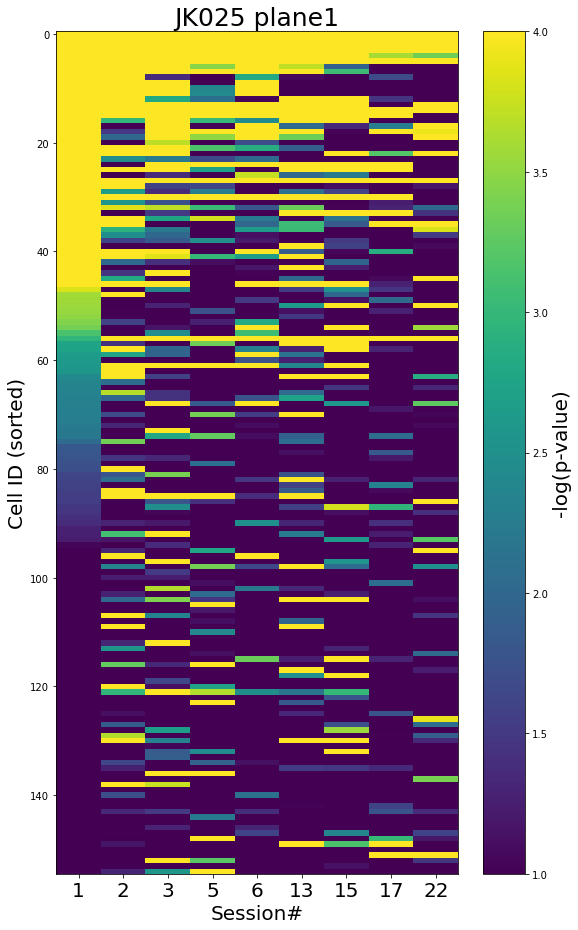

In [454]:
# pre-answer touch response p-value, sorted by first session, per plane
num_roi = tr_crude.num_roi.values[0]
session_nums = tr_crude.session.values
p_pre_answer = []
for ppa in tr_crude.p_pre_answer.values:
    if len(p_pre_answer) == 0:
        p_pre_answer = -np.log10(ppa)
    else:
        p_pre_answer = np.vstack((p_pre_answer, -np.log10(ppa)))
p_pre_answer = p_pre_answer.transpose()
sort_i = np.argsort(-p_pre_answer[:,0])
sort_p_pre_answer = p_pre_answer[sort_i,:]

fig, ax = plt.subplots(figsize=(p_pre_answer.shape[1],p_pre_answer.shape[0]/10))
p_matrix = ax.imshow(sort_p_pre_answer, vmin=1, vmax=4, aspect='auto')
ax.set_xticks(range(len(session_nums)))
ax.set_xticklabels(session_nums, fontsize=20)
ax.set_xlabel('Session#', fontsize=20)
ax.set_ylabel('Cell ID (sorted)', fontsize=20)
cb = fig.colorbar(p_matrix, ax=ax).set_label(label='-log(p-value)', size=20)
# cb.ax.tick_params(labelsize=15)
ax.set_title(f'JK{mouse:03d} plane{plane}', fontsize=25)




Text(0.5, 1.0, 'JK025 plane1')

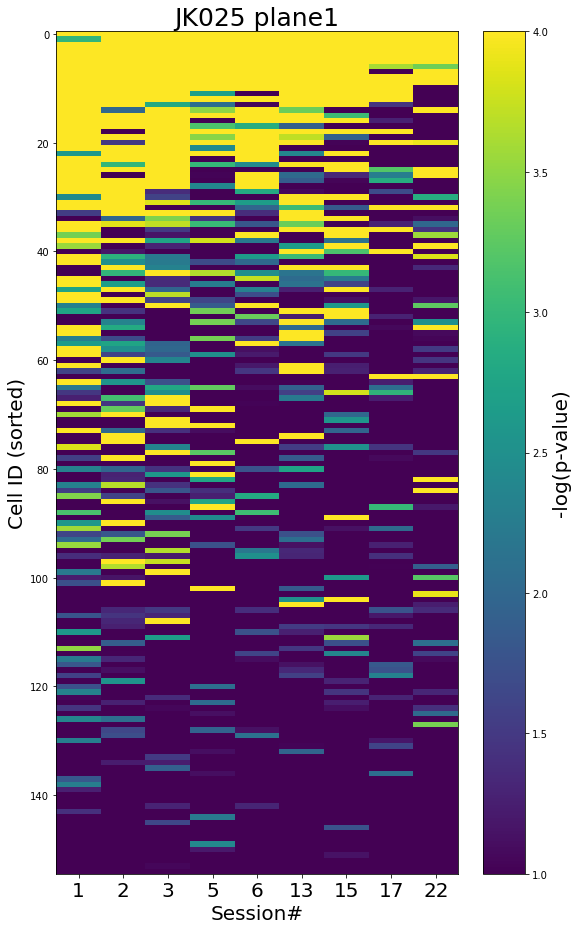

In [455]:
# pre-answer touch response p-value, sorted by session mean, per plane
num_roi = tr_crude.num_roi.values[0]
session_nums = tr_crude.session.values
p_pre_answer = []
for ppa in tr_crude.p_pre_answer.values:
    if len(p_pre_answer) == 0:
        p_pre_answer = -np.log10(ppa)
    else:
        p_pre_answer = np.vstack((p_pre_answer, -np.log10(ppa)))
p_pre_answer = p_pre_answer.transpose()
sort_i = np.argsort(-np.mean(p_pre_answer[:,],axis=1))
sort_p_pre_answer = p_pre_answer[sort_i,:]

fig, ax = plt.subplots(figsize=(p_pre_answer.shape[1],p_pre_answer.shape[0]/10))
p_matrix = ax.imshow(sort_p_pre_answer, vmin=1, vmax=4, aspect='auto')
ax.set_xticks(range(len(session_nums)))
ax.set_xticklabels(session_nums, fontsize=20)
ax.set_xlabel('Session#', fontsize=20)
ax.set_ylabel('Cell ID (sorted)', fontsize=20)
cb = fig.colorbar(p_matrix, ax=ax).set_label(label='-log(p-value)', size=20)
# cb.ax.tick_params(labelsize=15)
ax.set_title(f'JK{mouse:03d} plane{plane}', fontsize=25)

Text(0.5, 1.0, 'JK025 plane1\nTask performance')

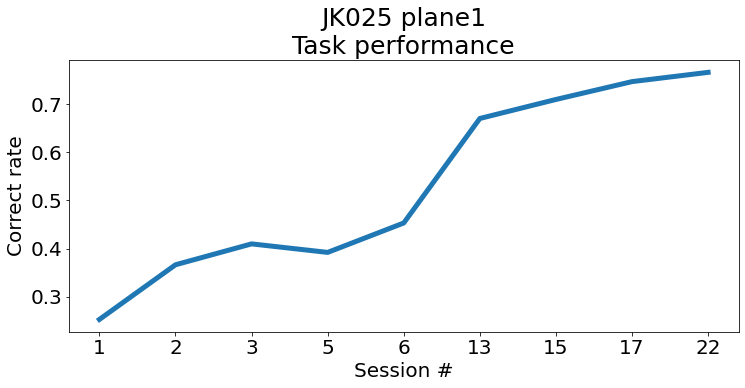

In [472]:
# volume-wise task performance graph
task_performance = tr_crude.correct_rate.values
session_nums = tr_crude.session.values
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(range(len(session_nums)), task_performance, linewidth=5)
ax.set_xticks(range(len(session_nums)))
ax.set_xticklabels(session_nums, fontsize=20)
ax.tick_params(axis='both', labelsize=20)
ax.set_xlabel('Session #', fontsize=20)
ax.set_ylabel('Correct rate', fontsize=20)
ax.set_title(f'JK{mouse:03d} plane{plane}\nTask performance', fontsize=25)

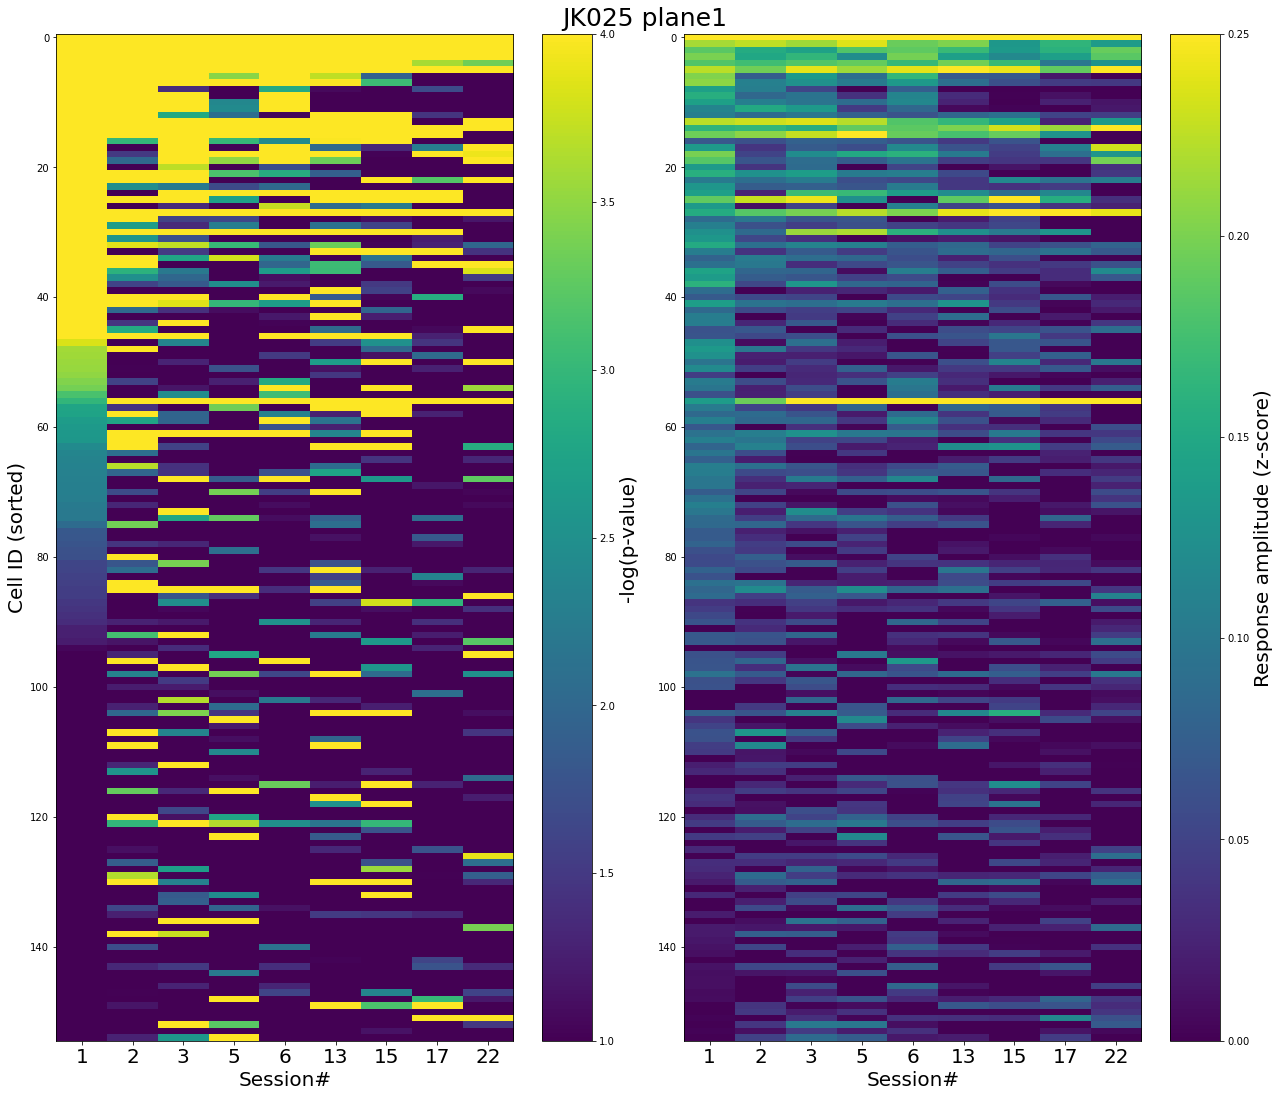

In [465]:
# pre-answer touch response effect size, sorted by p-value of first session, per plane
num_roi = tr_crude.num_roi.values[0]
session_nums = tr_crude.session.values
p_pre_answer = []
for ppa in tr_crude.p_pre_answer.values:
    if len(p_pre_answer) == 0:
        p_pre_answer = -np.log10(ppa)
    else:
        p_pre_answer = np.vstack((p_pre_answer, -np.log10(ppa)))
p_pre_answer = p_pre_answer.transpose()
sort_i = np.argsort(-p_pre_answer[:,0])
sort_p_pre_answer = p_pre_answer[sort_i,:]

effect_pre_answer = []
for epa in tr_crude.effect_size_pre_answer.values:
    if len(effect_pre_answer) == 0:
        effect_pre_answer = epa
    else:
        effect_pre_answer = np.vstack((effect_pre_answer, epa))
effect_pre_answer = effect_pre_answer.transpose()
sort_e_pre_answer = effect_pre_answer[sort_i, :]

fig, ax = plt.subplots(1,2,figsize=(effect_pre_answer.shape[1]*2,effect_pre_answer.shape[0]/10))
p_matrix = ax[0].imshow(sort_p_pre_answer, vmin=1, vmax=4, aspect='auto')
ax[0].set_xticks(range(len(session_nums)))
ax[0].set_xticklabels(session_nums, fontsize=20)
ax[0].set_xlabel('Session#', fontsize=20)
ax[0].set_ylabel('Cell ID (sorted)', fontsize=20)
cb = fig.colorbar(p_matrix, ax=ax[0]).set_label(label='-log(p-value)', size=20)
# cb.ax.tick_params(labelsize=15)
e_matrix = ax[1].imshow(sort_e_pre_answer, vmin=0, vmax=0.25, aspect='auto')
ax[1].set_xticks(range(len(session_nums)))
ax[1].set_xticklabels(session_nums, fontsize=20)
ax[1].set_xlabel('Session#', fontsize=20)
cb = fig.colorbar(e_matrix, ax=ax[1]).set_label(label='Response amplitude (z-score)', size=20)
fig.suptitle(f'JK{mouse:03d} plane{plane}', fontsize=25)
fig.tight_layout()

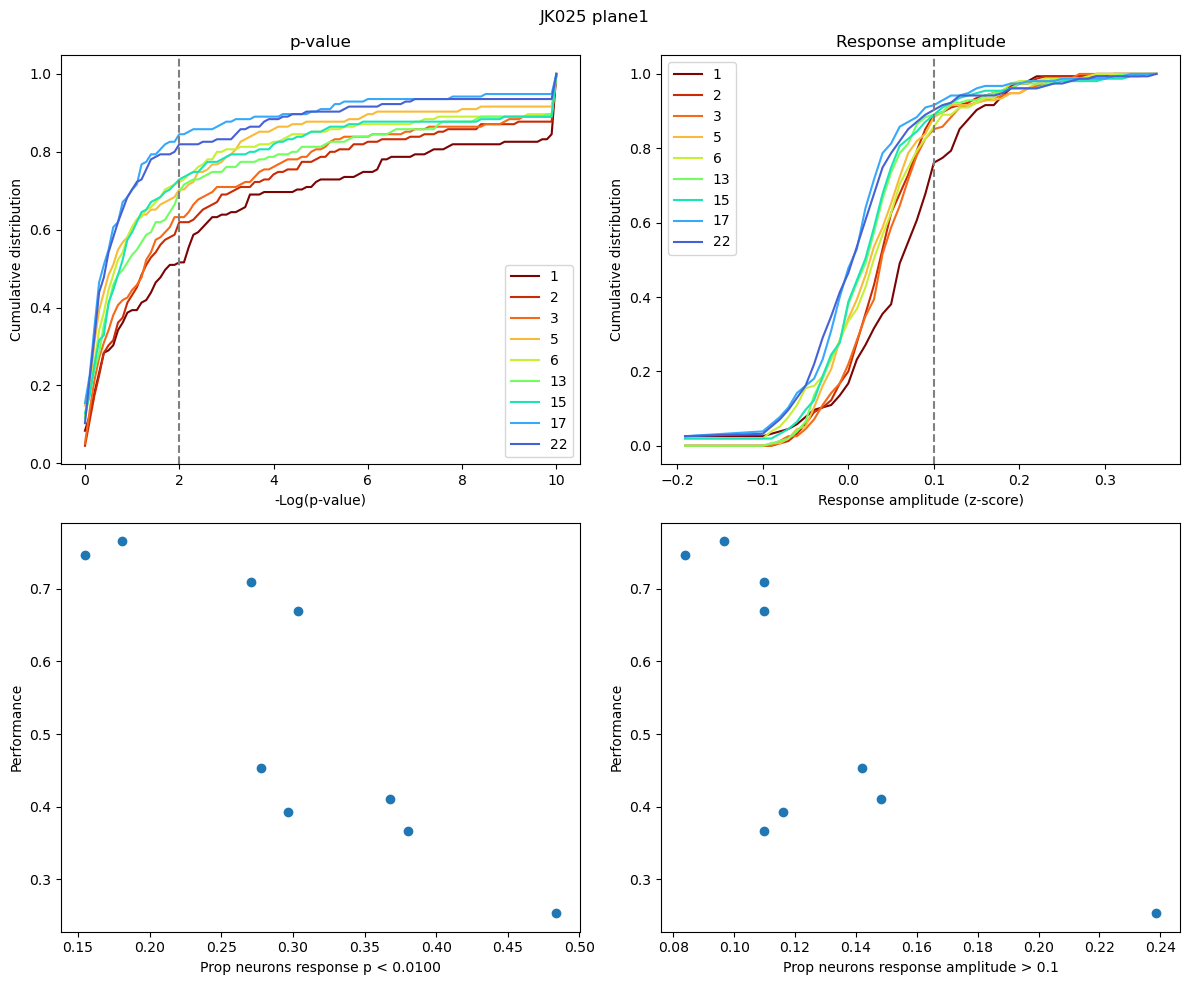

In [149]:
# Distribution of touch-responsive neurons across training
# Not following up the same cells, just population distribution per session
import matplotlib as mpl
cmap = mpl.cm.get_cmap('turbo')
task_performance = tr_crude.correct_rate.values
target_logp_value = 2
target_response = 0.1

num_roi = tr_crude.num_roi.values[0]
session_nums = tr_crude.session.values
num_sessions = len(session_nums)
p_pre_answer = []
for ppa in tr_crude.p_pre_answer.values:
    if len(p_pre_answer) == 0:
        p_pre_answer = -np.log10(ppa)
    else:
        p_pre_answer = np.vstack((p_pre_answer, -np.log10(ppa)))
p_bins = [*np.round(np.arange(0,10.1,0.1),2), 10**3]
p_pre_answer_cumdist = []
for i in range(num_sessions):
    cumdist = np.cumsum(np.histogram(p_pre_answer[i,:], bins=p_bins)[0]/num_roi)
    if len(p_pre_answer_cumdist) == 0:
        p_pre_answer_cumdist = cumdist.copy()
    else:
        p_pre_answer_cumdist = np.vstack((p_pre_answer_cumdist, cumdist))

effect_pre_answer = []
for epa in tr_crude.effect_size_pre_answer.values:
    if len(effect_pre_answer) == 0:
        effect_pre_answer = epa.copy()
    else:
        effect_pre_answer = np.vstack((effect_pre_answer, epa))
min_effect = np.amin(effect_pre_answer)
max_effect = np.amax(effect_pre_answer)
e_bins = [min_effect, *np.round(np.arange(-0.1,max_effect+0.01,0.01),2)]
e_pre_answer_cumdist = []
for i in range(num_sessions):
    cumdist = np.cumsum(np.histogram(effect_pre_answer[i,:], bins=e_bins)[0]/num_roi)
    if len(e_pre_answer_cumdist) == 0:
        e_pre_answer_cumdist = cumdist.copy()
    else:
        e_pre_answer_cumdist = np.vstack((e_pre_answer_cumdist, cumdist))

fig, ax = plt.subplots(2,2,figsize=(12,10))
for i in range(num_sessions):
    color_val = (1-i/num_sessions)
    # ax[0].plot(p_bins[:-1], p_pre_answer_cumdist[i], color= np.array([1,1,1]) - np.array([*cmap(color_val)])[:-1], label=f'{session_nums[i]}')
    ax[0,0].plot(p_bins[:-1], p_pre_answer_cumdist[i], color= cmap(color_val), label=f'{session_nums[i]}')
ax[0,0].legend()
ax[0,0].set_xlabel('-Log(p-value)')
ax[0,0].set_ylabel('Cumulative distribution')
ax[0,0].set_title('p-value')
ax[0,0].axvline(2, color=[0.5, 0.5, 0.5], linestyle='--')

for i in range(num_sessions):
    color_val = (1-i/num_sessions)
    ax[0,1].plot(e_bins[:-1], e_pre_answer_cumdist[i], color= cmap(color_val), label=f'{session_nums[i]}')
ax[0,1].axvline(0.1, color=[0.5,0.5,0.5], linestyle='--')
ax[0,1].legend()
ax[0,1].set_xlabel('Response amplitude (z-score)')
ax[0,1].set_ylabel('Cumulative distribution')
ax[0,1].set_title('Response amplitude')

fig.suptitle(f'JK{mouse:03d} plane{plane}')

ax[1,0].scatter(1-p_pre_answer_cumdist[:,np.argmin(np.abs(np.array(p_bins)-target_logp_value))], task_performance)
ax[1,0].set_ylabel('Performance')
ax[1,0].set_xlabel(f'Prop neurons response p < {10**(-target_logp_value):.4f}')

ax[1,1].scatter(1-e_pre_answer_cumdist[:,np.argmin(np.abs(np.array(e_bins)-target_response))], task_performance)
ax[1,1].set_ylabel('Performance')
ax[1,1].set_xlabel(f'Prop neurons response amplitude > {target_response}')

fig.tight_layout()


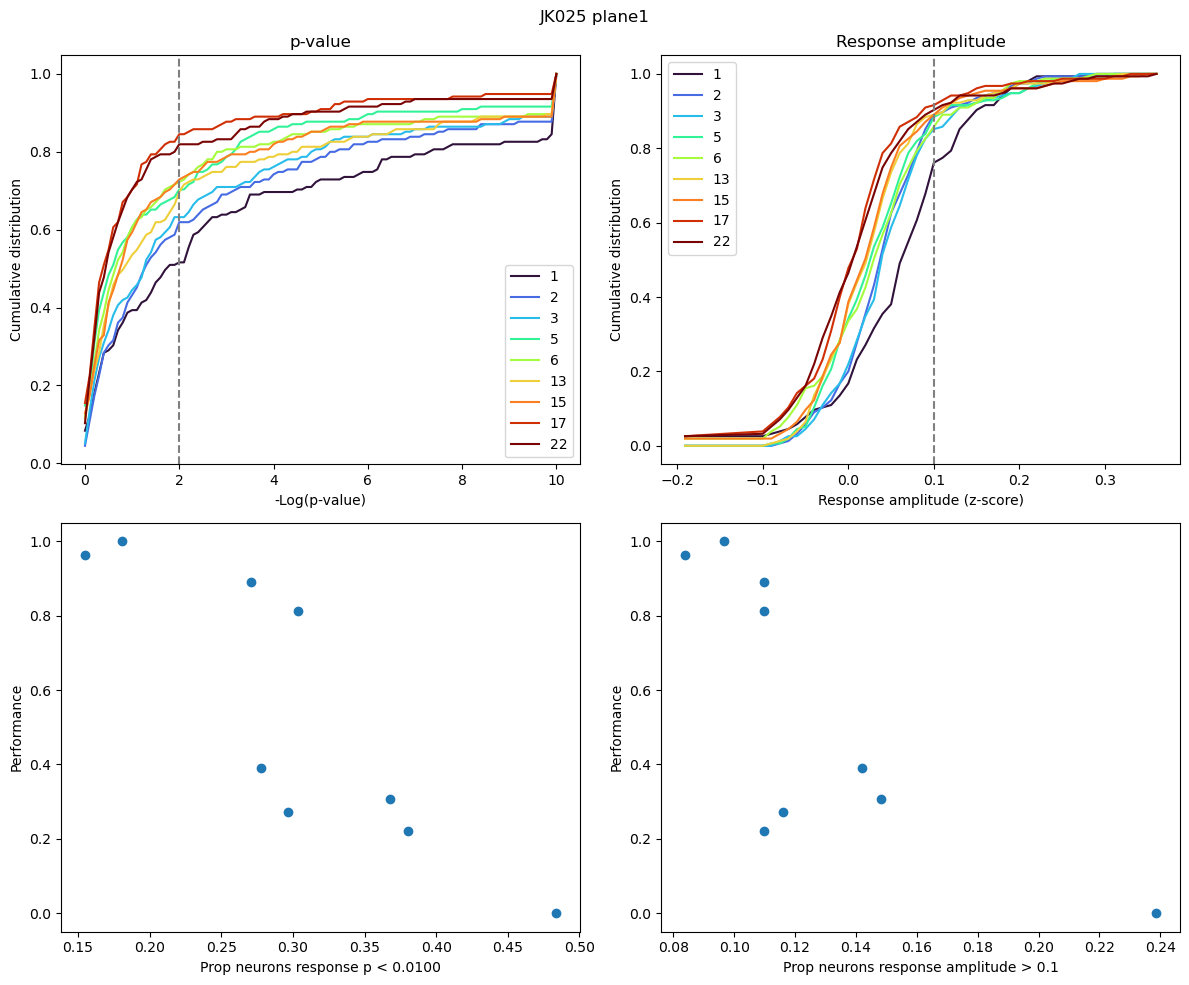

In [147]:
cmap = mpl.cm.get_cmap('turbo')
task_performance = tr_crude.correct_rate.values
target_logp_value = 2
target_response = 0.1

fig, ax = plt.subplots(2,2,figsize=(12,10))
for i in range(num_sessions):
    color_val = i/(num_sessions-1)
    ax[0,0].plot(p_bins[:-1], p_pre_answer_cumdist[i], color= cmap(color_val), label=f'{session_nums[i]}')
ax[0,0].legend()
ax[0,0].set_xlabel('-Log(p-value)')
ax[0,0].set_ylabel('Cumulative distribution')
ax[0,0].set_title('p-value')
ax[0,0].axvline(2, color=[0.5, 0.5, 0.5], linestyle='--')

for i in range(num_sessions):
    color_val = i/(num_sessions-1)
    ax[0,1].plot(e_bins[:-1], e_pre_answer_cumdist[i], color= cmap(color_val), label=f'{session_nums[i]}')
ax[0,1].axvline(0.1, color=[0.5,0.5,0.5], linestyle='--')
ax[0,1].legend()
ax[0,1].set_xlabel('Response amplitude (z-score)')
ax[0,1].set_ylabel('Cumulative distribution')
ax[0,1].set_title('Response amplitude')
fig.suptitle(f'JK{mouse:03d} plane{plane}')

ax[1,0].scatter(1-p_pre_answer_cumdist[:,np.argmin(np.abs(np.array(p_bins)-target_logp_value))], task_performance)
ax[1,0].set_ylabel('Performance')
ax[1,0].set_xlabel(f'Prop neurons response p < {10**(-target_logp_value):.4f}')

ax[1,1].scatter(1-e_pre_answer_cumdist[:,np.argmin(np.abs(np.array(e_bins)-target_response))], task_performance)
ax[1,1].set_ylabel('Performance')
ax[1,1].set_xlabel(f'Prop neurons response amplitude > {target_response}')

fig.tight_layout()

In [125]:
np.argmin(np.abs(np.array(p_bins)-target_logp_value))

20

In [9]:
# functions to visualize individual plane
def plot_performance(tr_crude):
    task_performance = tr_crude.correct_rate.values
    session_nums = tr_crude.session.values
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(range(len(session_nums)), task_performance, linewidth=5)
    ax.set_xticks(range(len(session_nums)))
    ax.set_xticklabels(session_nums, fontsize=20)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlabel('Session #', fontsize=20)
    ax.set_ylabel('Correct rate', fontsize=20)
    ax.set_title(f'JK{mouse:03d} plane{plane}\nTask performance', fontsize=25)

def plot_response(tr_crude, sort_by, mouse, plane):
    num_roi = tr_crude.num_roi.values[0]
    session_nums = tr_crude.session.values

    p_pre_answer = []
    for ppa in tr_crude.p_pre_answer.values:
        if len(p_pre_answer) == 0:
            p_pre_answer = -np.log10(ppa)
        else:
            p_pre_answer = np.vstack((p_pre_answer, -np.log10(ppa)))
    p_pre_answer = p_pre_answer.transpose()
    if sort_by == 'first':
        sort_i = np.argsort(-p_pre_answer[:,0])
    elif sort_by == 'mean':
        sort_i = np.argsort(-np.nanmean(p_pre_answer[:,],axis=1))
    else:
        raise('sort_by should be defined, either ''first'' or ''mean''.')
    sort_p_pre_answer = p_pre_answer[sort_i,:]
    effect_pre_answer = []
    for epa in tr_crude.effect_size_pre_answer.values:
        if len(effect_pre_answer) == 0:
            effect_pre_answer = epa
        else:
            effect_pre_answer = np.vstack((effect_pre_answer, epa))
    effect_pre_answer = effect_pre_answer.transpose()
    sort_e_pre_answer = effect_pre_answer[sort_i, :]

    fig, ax = plt.subplots(1,2,figsize=(effect_pre_answer.shape[1],effect_pre_answer.shape[0]/20))
    # fig, ax = plt.subplots(1,2,figsize=(10,20))
    p_matrix = ax[0].imshow(sort_p_pre_answer, vmin=1, vmax=4, aspect='auto')
    ax[0].set_xticks(range(len(session_nums)))
    ax[0].set_xticklabels(session_nums, fontsize=20)
    ax[0].set_xlabel('Session#', fontsize=20)
    ax[0].set_ylabel('Cell ID (sorted)', fontsize=20)
    cb = fig.colorbar(p_matrix, ax=ax[0]).set_label(label='-log(p-value)', size=20)
    # cb.ax.tick_params(labelsize=15)
    e_matrix = ax[1].imshow(sort_e_pre_answer, vmin=0, vmax=0.25, aspect='auto')
    ax[1].set_xticks(range(len(session_nums)))
    ax[1].set_xticklabels(session_nums, fontsize=20)
    ax[1].set_xlabel('Session#', fontsize=20)
    cb = fig.colorbar(e_matrix, ax=ax[1]).set_label(label='Response amplitude (z-score)', size=20)
    fig.suptitle(f'JK{mouse:03d} plane{plane}', fontsize=25)
    fig.tight_layout()

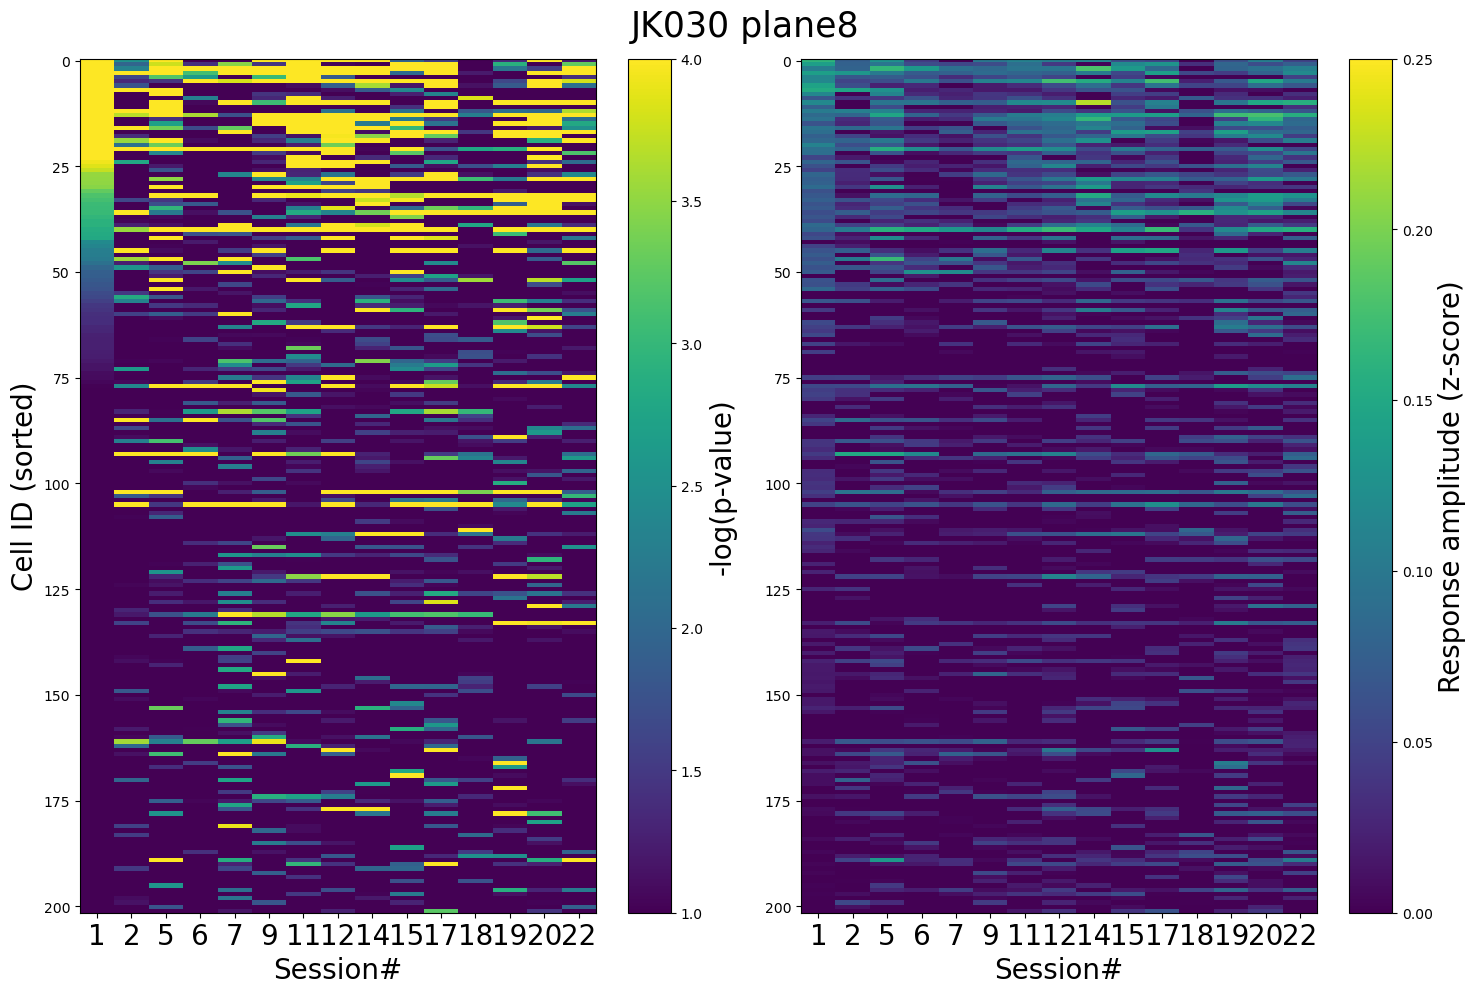

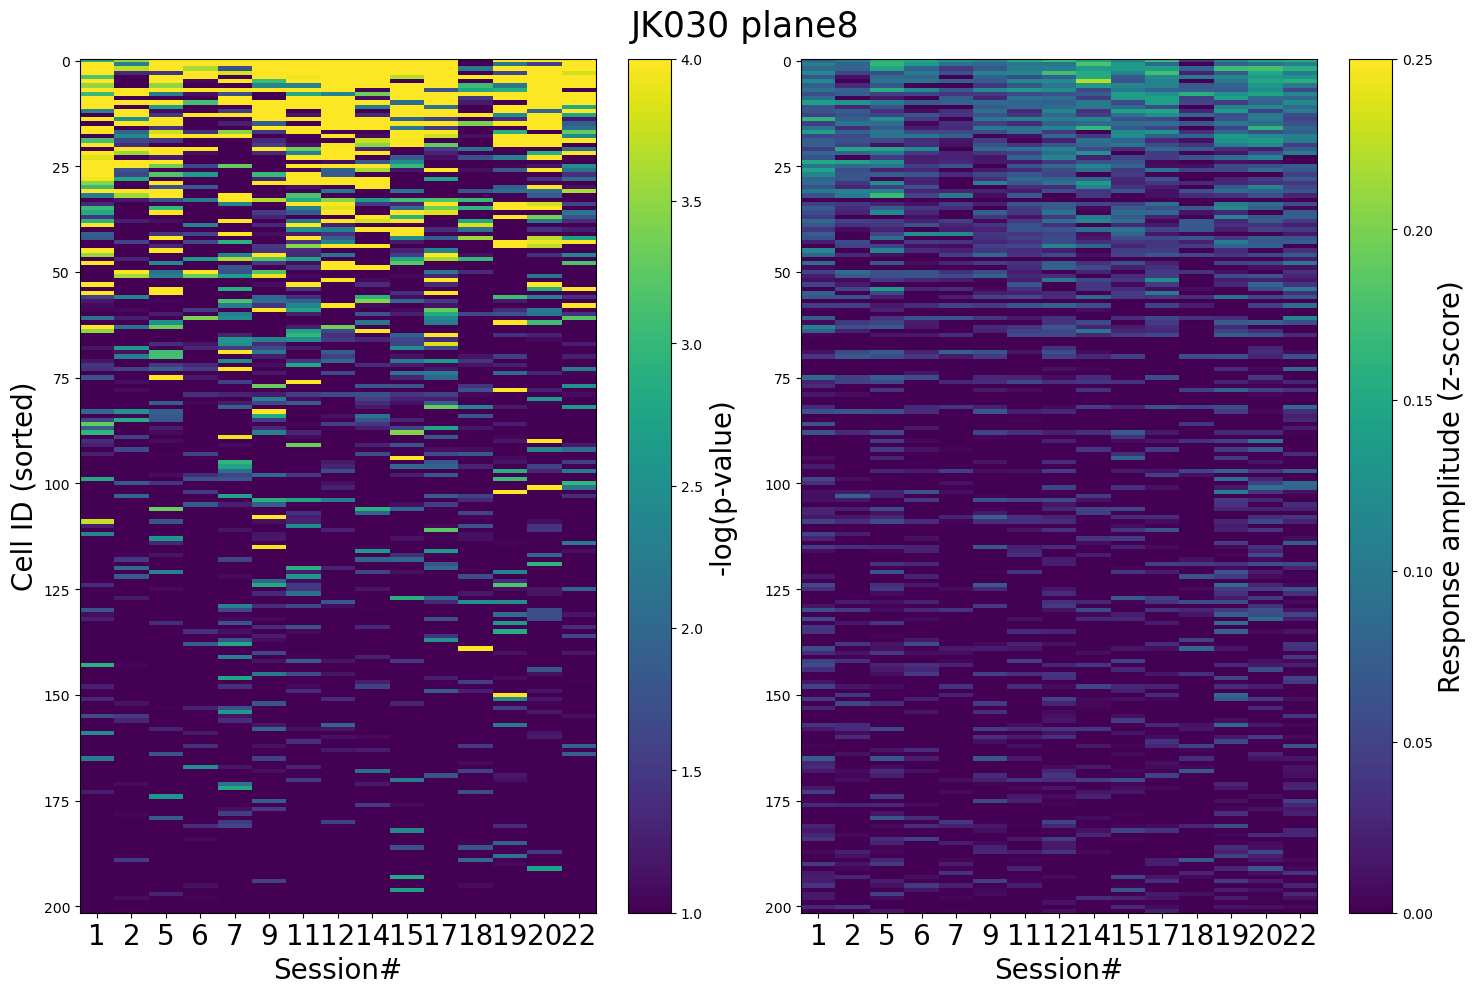

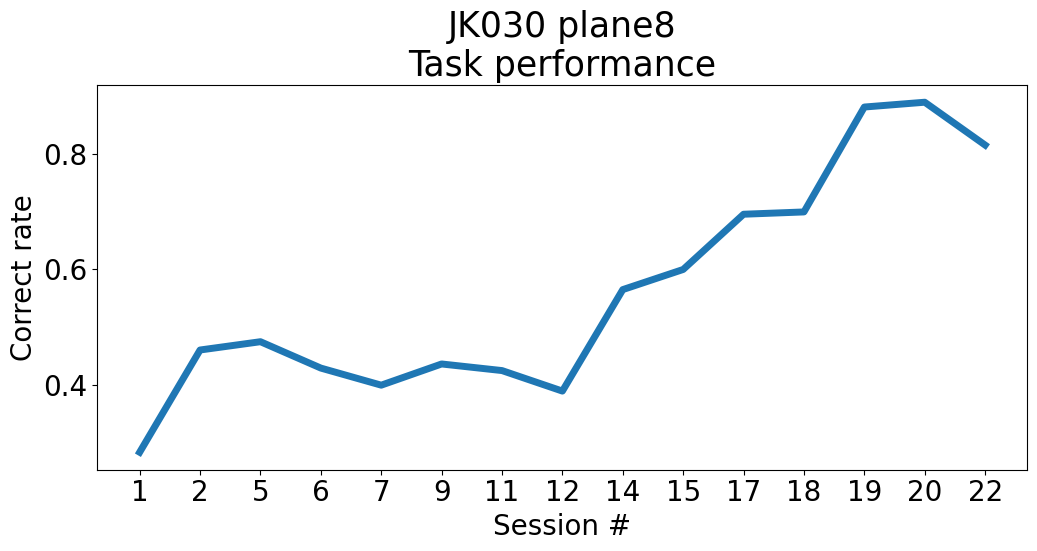

In [29]:
# Visit each individual mouse
mouse = 30
plane = 8
load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
tr_crude = pd.read_pickle(save_dir / load_fn)
plot_response(tr_crude, 'first', mouse, plane)
plot_response(tr_crude, 'mean', mouse, plane)
plot_performance(tr_crude)

In [185]:
def touch_response_prop_plot(tr_crude, target_logp_value=2, target_response=None):
    cmap = mpl.cm.get_cmap('turbo')
    task_performance = tr_crude.correct_rate.values
    num_roi = tr_crude.num_roi.values[0]
    session_nums = tr_crude.session.values
    num_sessions = len(session_nums)
    p_pre_answer = []
    for ppa in tr_crude.p_pre_answer.values:
        if len(p_pre_answer) == 0:
            p_pre_answer = -np.log10(ppa)
        else:
            p_pre_answer = np.vstack((p_pre_answer, -np.log10(ppa)))
    p_bins = [*np.round(np.arange(0,10.1,0.1),2), 10**3]
    p_pre_answer_cumdist = []
    for i in range(num_sessions):
        cumdist = np.cumsum(np.histogram(p_pre_answer[i,:], bins=p_bins)[0]/num_roi)
        if len(p_pre_answer_cumdist) == 0:
            p_pre_answer_cumdist = cumdist.copy()
        else:
            p_pre_answer_cumdist = np.vstack((p_pre_answer_cumdist, cumdist))

    effect_pre_answer = []
    for epa in tr_crude.effect_size_pre_answer.values:
        if len(effect_pre_answer) == 0:
            effect_pre_answer = epa.copy()
        else:
            effect_pre_answer = np.vstack((effect_pre_answer, epa))
    min_effect = np.percentile(effect_pre_answer[:],0.5)
    max_effect = np.amax(effect_pre_answer)
    e_bins = [*np.round(np.arange(min_effect,max_effect+0.01,0.01),2)]
    e_pre_answer_cumdist = []
    for i in range(num_sessions):
        cumdist = np.cumsum(np.histogram(effect_pre_answer[i,:], bins=e_bins)[0]/num_roi)
        if len(e_pre_answer_cumdist) == 0:
            e_pre_answer_cumdist = cumdist.copy()
        else:
            e_pre_answer_cumdist = np.vstack((e_pre_answer_cumdist, cumdist))

    fig, ax = plt.subplots(2,2,figsize=(12,10))
    for i in range(num_sessions):
        color_val = 1-i/(num_sessions-1)
        # ax[0].plot(p_bins[:-1], p_pre_answer_cumdist[i], color= np.array([1,1,1]) - np.array([*cmap(color_val)])[:-1], label=f'{session_nums[i]}')
        ax[0,0].plot(p_bins[:-1], p_pre_answer_cumdist[i], color= cmap(color_val), label=f'{session_nums[i]}')
    ax[0,0].legend()
    ax[0,0].set_xlabel('-Log(p-value)')
    ax[0,0].set_ylabel('Cumulative distribution')
    ax[0,0].set_title('p-value')
    ax[0,0].axvline(2, color=[0.5, 0.5, 0.5], linestyle='--')

    for i in range(num_sessions):
        color_val = 1-i/(num_sessions-1)
        ax[0,1].plot(e_bins[:-1], e_pre_answer_cumdist[i], color= cmap(color_val), label=f'{session_nums[i]}')
    
    ax[0,1].legend()
    ax[0,1].set_xlabel('Response amplitude (z-score)')
    ax[0,1].set_ylabel('Cumulative distribution')
    ax[0,1].set_title('Response amplitude')

    fig.suptitle(f'JK{mouse:03d} plane{plane}')

    ax[1,0].scatter(1-p_pre_answer_cumdist[:,np.argmin(np.abs(np.array(p_bins)-target_logp_value))], task_performance, c = 1-np.array(range(num_sessions))/(num_sessions-1), cmap=cmap)
    ax[1,0].set_ylabel('Performance')
    ax[1,0].set_xlabel(f'Prop neurons response p < {10**(-target_logp_value):.4f}')

    if target_response is None:
        e_ind = np.argmin(np.abs(np.mean(e_pre_answer_cumdist,axis=0)-0.8))
        target_response = e_bins[e_ind]
    else:
        e_ind = np.argmin(np.abs(np.array(e_bins)-target_response))
    ax[1,1].scatter(1-e_pre_answer_cumdist[:,e_ind], task_performance, c = 1-np.array(range(num_sessions))/(num_sessions-1), cmap=cmap)
    ax[1,1].set_ylabel('Performance')
    ax[1,1].set_xlabel(f'Prop neurons response amplitude > {target_response}')

    ax[0,1].axvline(target_response, color=[0.5,0.5,0.5], linestyle='--')


    fig.tight_layout()

In [ ]:

mouse = 30
for plane in range(1,9):
    load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
    tr_crude = pd.read_pickle(save_dir / load_fn)
    touch_response_prop_plot(tr_crude)



# Tuning
- Among touch responsive neurons.
    - Defined by p < 0.01, as it roughly corresponds to 20-30% of neurons (similar to previous analyses, Peron 2015; Kim 2020)
- Tuning defined by t-test

In [2]:
# Test in a single plane
mouse = 25
plane = 1
load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
tr_crude = pd.read_pickle(save_dir_base / load_fn)
tr_crude.head()

,session,num_roi,correct_rate,num_answer,num_touch_trials,pre_pole_len,angle,correct,num_touch_pre_answer,num_touch_post_answer,p_pre_answer,p_post_answer,effect_size_pre_answer,effect_size_post_answer,effect_size_post_pre,pre_pole_activity,pre_answer_response,post_answer_response,post_pole_activity
0,1,155,0.253333,87,86,"[7.0, 5.0, nan, nan, 4.0, 4.0, 5.0, 5.0, nan, ...","[135.0, 45.0, nan, nan, 135.0, 135.0, 45.0, 45...","[1.0, 0.0, nan, nan, 1.0, 1.0, 0.0, 1.0, nan, ...","[18.0, 11.0, nan, nan, 10.0, 2.0, 31.0, 9.0, n...","[9.0, 0.0, nan, nan, 6.0, 1.0, 0.0, 2.0, nan, ...","[0.05462005333855603, 0.038138848871334396, 0....","[0.1896998831091713, 0.002088746378560182, 0.5...","[-0.17202586743104106, 0.054016240154776504, 0...","[-0.18187763485567351, 0.05931664383234946, 0....","[-0.006120940053684486, 0.0029957850992276863,...","[[2.4701406955718994, -0.07326578348875046, -0...","[[-0.01131864357739687, -0.006261858623474836,...","[[-0.02263728715479374, -0.012523717246949673,...","[[-0.2037355899810791, -0.09747523069381714, -..."
1,2,155,0.366667,253,243,"[nan, 5.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...","[nan, 45.0, 135.0, 135.0, 135.0, 45.0, 135.0, ...","[nan, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[nan, 17.0, 1.0, 2.0, 12.0, 3.0, 3.0, 32.0, 5....","[nan, 10.0, 9.0, 8.0, 8.0, 0.0, 9.0, 0.0, 9.0,...","[0.16372746908055585, 0.780889262442506, 0.001...","[0.022107064466546845, 0.0002746757374027414, ...","[0.029681583434949848, -0.009315722820284603, ...","[0.059255056773731926, 0.0526835562055601, 0.0...","[0.011599503465234038, -0.013934353604541547, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2,3,155,0.410000,173,167,"[nan, 5.0, 4.0, 5.0, 5.0, nan, nan, 5.0, 5.0, ...","[nan, 45.0, 135.0, 45.0, 45.0, nan, nan, 135.0...","[nan, 0.0, 0.0, 1.0, 0.0, nan, nan, 1.0, 1.0, ...","[nan, 5.0, 16.0, 9.0, 3.0, nan, nan, 12.0, 12....","[nan, 0.0, 0.0, 10.0, 0.0, nan, nan, 11.0, 8.0...","[0.2315996254378956, 0.4345311659808603, 2.886...","[0.7218874753726268, 0.7093547762237524, 0.073...","[-0.03776196547603363, 0.01797069675001716, 0....","[-0.017949527353244687, 0.013026928506701826, ...","[0.020200847787291643, 0.01291088764387441, 0....","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
3,5,155,0.392344,174,164,"[nan, nan, nan, nan, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[nan, nan, nan, nan, 45.0, 135.0, 45.0, 45.0, ...","[nan, nan, nan, nan, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[nan, nan, nan, nan, 1.0, 7.0, 2.0, 1.0, 5.0, ...","[nan, nan, nan, nan, 0.0, 4.0, 0.0, 0.0, 6.0, ...","[0.4056831585421393, 0.49430027748864735, 0.00...","[0.01822982221892959, 0.006557236225658384, 2....","[-0.05995432152150327, -0.06158196754841852, 0...","[0.12275546350917202, 0.06835792674403048, 0.0...","[0.044259421180279736, 0.017738409908762312, 0...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
4,6,155,0.453333,139,124,"[7.0, 4.0, nan, 4.0, 5.0, 5.0, 5.0, 4.0, nan, ...","[45.0, 135.0, nan, 135.0, 135.0, 135.0, 135.0,...","[0.0, 1.0, nan, 0.0, 0.0, 1.0, 1.0, 0.0, nan, ...","[15.0, 12.0, nan, 9.0, 7.0, 11.0, 2.0, 2.0, na...","[0.0, 5.0, nan, 0.0, 0.0, 7.0, 2.0, 0.0, nan, ...","[0.14304585178049292, 0.11602419863446474, 0.0...","[0.6569414127785262, 0.9275778027115644, 0.869...","[-0.08980169741069007, -0.0882484578041305, 0....","[0.02512161350387032, 0.003390853255041293, 0....","[0.0027886911776800784, -0.010648715130242882,...","[[0.9075766205787659, 0.8415799736976624, 0.00...","[[0.010356479324400425, -0.009447846561670303,...","[[nan, nan, nan, nan, nan, nan, nan, na

In [4]:
# Find angle-tuned neurons
def calculate_tuned_response(tr_crude, p_threshold_touch_response=0.01):    
    num_rois = tr_crude.iloc[0].num_roi
    session_nums = tr_crude.session.values
    num_sessions = len(session_nums)
    p_tuned = np.empty((num_sessions,num_rois))
    p_tuned[:] = np.nan
    effect_tuned = np.empty((num_sessions,num_rois))
    effect_tuned[:] = np.nan

    for si in range(num_sessions):
        cell_ind_touch_response = np.where(tr_crude.iloc[si].p_pre_answer < p_threshold_touch_response)[0]
        trial_ind_45 = np.where(tr_crude.iloc[si].angle == 45)[0]
        trial_ind_135 = np.where(tr_crude.iloc[si].angle == 135)[0]
        pre_pole_activity = tr_crude.iloc[si].pre_pole_activity
        pre_answer_response = tr_crude.iloc[si].pre_answer_response
        touch_response = pre_answer_response - pre_pole_activity
        for ci in range(len(cell_ind_touch_response)):
            cell_ind = cell_ind_touch_response[ci]
            touch_response_45 = touch_response[trial_ind_45,cell_ind]
            finite_45_inds = np.where(np.isfinite(touch_response_45))[0]
            touch_response_135 = touch_response[trial_ind_135,cell_ind]
            finite_135_inds = np.where(np.isfinite(touch_response_135))[0]
            if (len(finite_45_inds) > 10) and (len(finite_135_inds) > 10):
                touch_response_45 = touch_response_45[finite_45_inds]
                touch_response_135 = touch_response_135[finite_135_inds]
                t = stats.ttest_ind(touch_response_45, touch_response_135)
                p = t.pvalue
                es = np.mean(touch_response_45) - np.mean(touch_response_135)

                p_tuned[si,ci] = p
                effect_tuned[si,ci] = es
    return p_tuned, effect_tuned



In [5]:
# Test in a single plane
mouse = 25
plane = 1
load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
tr_crude = pd.read_pickle(save_dir_base / load_fn)
p_tuned, effect_tuned = calculate_tuned_response(tr_crude)

In [568]:
tr_crude.iloc[0].num_roi

153

In [567]:
len(tr_crude.iloc[0].p_pre_answer)

153

In [570]:
tr_crude.p_pre_answer.apply(lambda x: len(np.where(x < 0.01)[0])).values

array([38, 30, 10, 11, 43, 45, 45, 46, 29, 60, 28,  8, 31, 32, 21, 23, 23],
      dtype=int64)

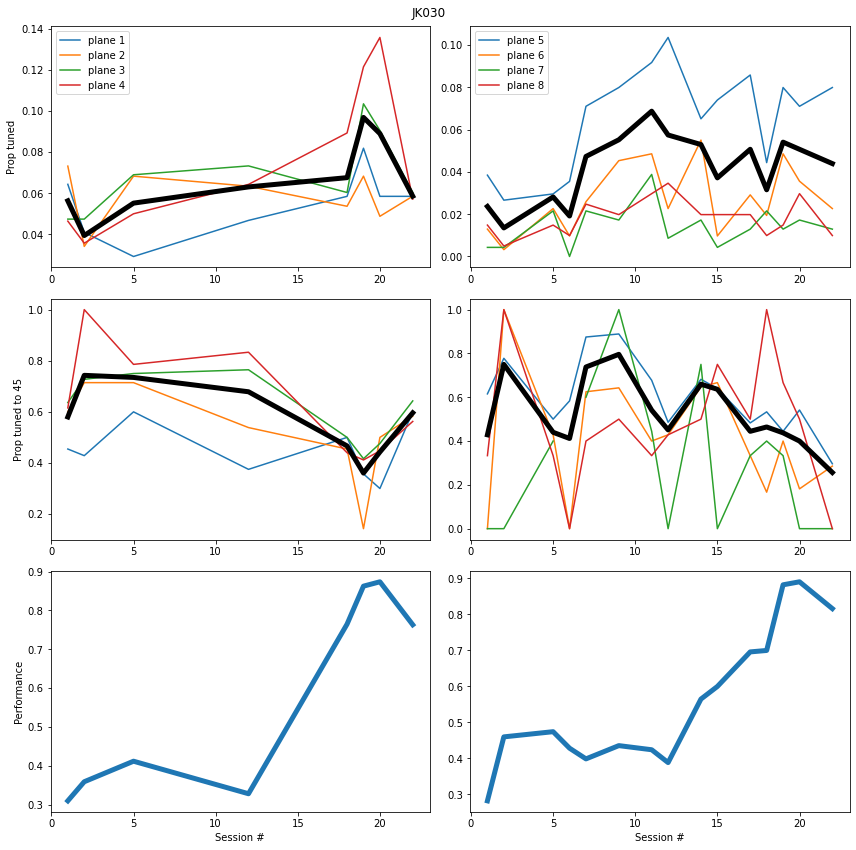

In [590]:
# Plot proportion change across training
# Per plane, within a volume
mouse = 30

cmap = mpl.cm.get_cmap('turbo')
p_threshold_tuned = 0.05
fig, ax = plt.subplots(3,2,figsize=(12,12))
planes = range(1,9)
session_nums_plane = []
num_roi_plane = []
num_tuned_plane = []
num_45_tuned_plane = []
num_touch_response_plane = []
for plane in planes:
    ax_col = 0 if plane < 5 else 1
    load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
    tr_crude = pd.read_pickle(save_dir_base / load_fn)
    session_nums = tr_crude.session.values
    session_nums_plane.append(session_nums)
    p_tuned, effect_tuned = calculate_tuned_response(tr_crude)
    
    num_sessions, num_rois = p_tuned.shape
    num_roi_plane.append(num_rois)

    len_touch_response = tr_crude.p_pre_answer.apply(lambda x: len(np.where(x < 0.01)[0])).values
    num_touch_response_plane.append(len_touch_response)

    len_tuned = np.zeros((num_sessions,))
    len_45_tuned = np.zeros((num_sessions,))
    prop_tuned = np.zeros((num_sessions,))
    prop_45_tuned = np.zeros((num_sessions,))
    prop_135_tuned = np.zeros((num_sessions,))
    for si in range(num_sessions):
        ind_tuned = np.where(p_tuned[si,:]<p_threshold_tuned)[0]
        len_tuned[si] = len(ind_tuned)

        ind_45_tuned = np.where(effect_tuned[si,ind_tuned]>0)[0]
        len_45_tuned[si] = len(ind_45_tuned)
        ind_135_tuned = np.where(effect_tuned[si,ind_tuned]<0)[0]
        prop_tuned[si] = len(ind_tuned) / num_rois
        if len(ind_tuned)>0:
            prop_45_tuned[si] = len(ind_45_tuned) / len(ind_tuned)
        else:
            prop_45_tuned[si] = np.nan
        # prop_135_tuned[si] = len(ind_135_tuned) / len(ind_tuned)
    num_tuned_plane.append(len_tuned)
    num_45_tuned_plane.append(len_45_tuned)
    

    ax[0,ax_col].plot(session_nums, prop_tuned, label=f'plane {plane}')
    ax[1,ax_col].plot(session_nums, prop_45_tuned, label=f'plane {plane}')

    if plane == 1:
        ax[2,0].plot(session_nums, tr_crude.correct_rate.values, linewidth=5)
    elif plane == 5:
        ax[2,1].plot(session_nums, tr_crude.correct_rate.values, linewidth=5)
for ai in range(2):
    ax[0,ai].legend()
    ax[2,ai].set_xlabel('Session #')
ax[0,0].set_ylabel('Prop tuned')
ax[1,0].set_ylabel('Prop tuned to 45')
ax[2,0].set_ylabel('Performance')

fig.suptitle(f'JK{mouse:03d}')
fig.tight_layout()

# Add volume mean data
for i in range(4):
    if i == 0:
        num_tuned = num_tuned_plane[i]
        num_45_tuned = num_45_tuned_plane[i]
    else:
        num_tuned = np.vstack((num_tuned, num_tuned_plane[i]))
        num_45_tuned = np.vstack((num_45_tuned, num_45_tuned_plane[i]))
mean_prop_tuned = np.sum(num_tuned,axis=0) / np.sum(num_roi_plane[:4])
mean_prop_45_tuned = np.sum(num_45_tuned, axis=0) / np.sum(num_tuned,axis=0)
ax[0,0].plot(session_nums_plane[0], mean_prop_tuned, 'k-', linewidth=5)
ax[1,0].plot(session_nums_plane[0], mean_prop_45_tuned, 'k-', linewidth=5)

for i in range(4,8):
    if i == 4:
        num_tuned = num_tuned_plane[i]
        num_45_tuned = num_45_tuned_plane[i]
    else:
        num_tuned = np.vstack((num_tuned, num_tuned_plane[i]))
        num_45_tuned = np.vstack((num_45_tuned, num_45_tuned_plane[i]))
mean_prop_tuned = np.sum(num_tuned,axis=0) / np.sum(num_roi_plane[:4])
mean_prop_45_tuned = np.sum(num_45_tuned, axis=0) / np.sum(num_tuned,axis=0)
ax[0,1].plot(session_nums_plane[4], mean_prop_tuned, 'k-', linewidth=5)
ax[1,1].plot(session_nums_plane[4], mean_prop_45_tuned, 'k-', linewidth=5)



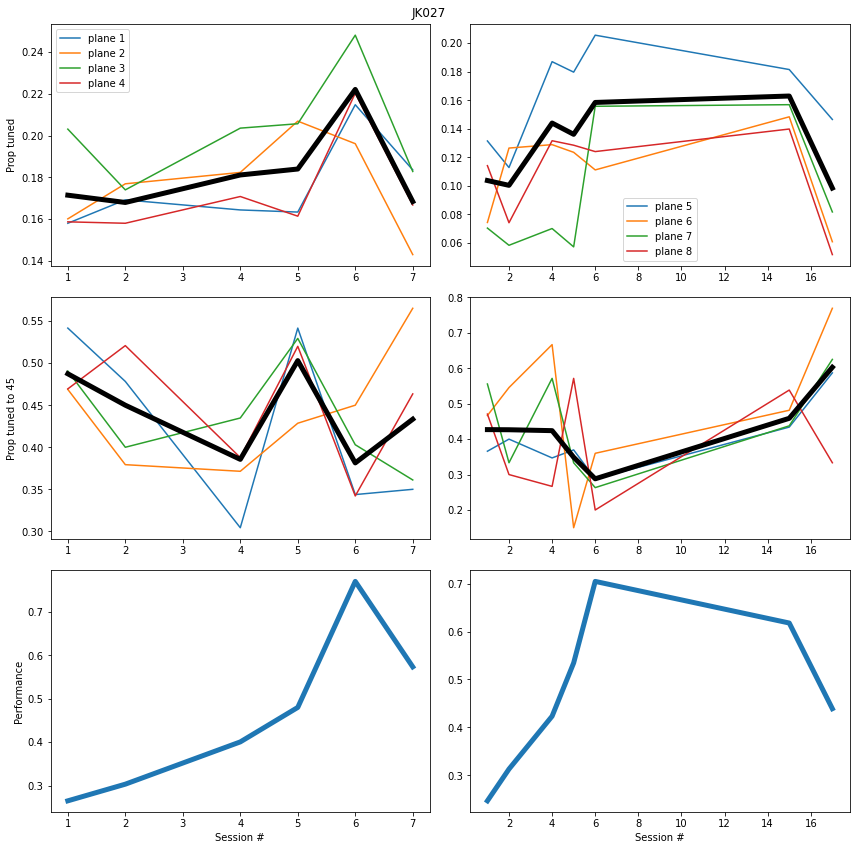

In [8]:
# Prop tuned PER touch neurons

# Plot proportion change across training
# Per plane, within a volume

mouse = 27

cmap = mpl.cm.get_cmap('turbo')
p_threshold_tuned = 0.05
fig, ax = plt.subplots(3,2,figsize=(12,12))
planes = range(1,9)
session_nums_plane = []
num_roi_plane = []
num_tuned_plane = []
num_45_tuned_plane = []
num_touch_response_plane = []
for plane in planes:
    ax_col = 0 if plane < 5 else 1
    load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
    tr_crude = pd.read_pickle(save_dir / load_fn)
    session_nums = tr_crude.session.values
    session_nums_plane.append(session_nums)
    p_tuned, effect_tuned = calculate_tuned_response(tr_crude)
    
    num_sessions, num_rois = p_tuned.shape
    num_roi_plane.append(num_rois)

    len_touch_response = tr_crude.p_pre_answer.apply(lambda x: len(np.where(x < 0.01)[0])).values
    num_touch_response_plane.append(len_touch_response)

    len_tuned = np.zeros((num_sessions,))
    len_45_tuned = np.zeros((num_sessions,))
    prop_tuned = np.zeros((num_sessions,))
    prop_45_tuned = np.zeros((num_sessions,))
    prop_135_tuned = np.zeros((num_sessions,))
    for si in range(num_sessions):
        ind_tuned = np.where(p_tuned[si,:]<p_threshold_tuned)[0]
        len_tuned[si] = len(ind_tuned)

        ind_45_tuned = np.where(effect_tuned[si,ind_tuned]>0)[0]
        len_45_tuned[si] = len(ind_45_tuned)
        ind_135_tuned = np.where(effect_tuned[si,ind_tuned]<0)[0]
        prop_tuned[si] = len(ind_tuned) / len_touch_response[si]
        if len(ind_tuned)>0:
            prop_45_tuned[si] = len(ind_45_tuned) / len(ind_tuned)
        else:
            prop_45_tuned[si] = np.nan
        # prop_135_tuned[si] = len(ind_135_tuned) / len(ind_tuned)
    num_tuned_plane.append(len_tuned)
    num_45_tuned_plane.append(len_45_tuned)
    

    ax[0,ax_col].plot(session_nums, prop_tuned, label=f'plane {plane}')
    ax[1,ax_col].plot(session_nums, prop_45_tuned, label=f'plane {plane}')

    if plane == 1:
        ax[2,0].plot(session_nums, tr_crude.correct_rate.values, linewidth=5)
    elif plane == 5:
        ax[2,1].plot(session_nums, tr_crude.correct_rate.values, linewidth=5)
for ai in range(2):
    ax[0,ai].legend()
    ax[2,ai].set_xlabel('Session #')
ax[0,0].set_ylabel('Prop tuned')
ax[1,0].set_ylabel('Prop tuned to 45')
ax[2,0].set_ylabel('Performance')

fig.suptitle(f'JK{mouse:03d}')
fig.tight_layout()

# Add volume mean data
for i in range(4):
    if i == 0:
        num_tuned = num_tuned_plane[i]
        num_45_tuned = num_45_tuned_plane[i]
        num_touch = num_touch_response_plane[i]
    else:
        num_tuned = np.vstack((num_tuned, num_tuned_plane[i]))
        num_45_tuned = np.vstack((num_45_tuned, num_45_tuned_plane[i]))
        num_touch = np.vstack((num_touch, num_touch_response_plane[i]))
mean_prop_tuned = np.sum(num_tuned,axis=0) / np.sum(num_touch, axis=0)
mean_prop_45_tuned = np.sum(num_45_tuned, axis=0) / np.sum(num_tuned,axis=0)
ax[0,0].plot(session_nums_plane[0], mean_prop_tuned, 'k-', linewidth=5)
ax[1,0].plot(session_nums_plane[0], mean_prop_45_tuned, 'k-', linewidth=5)

for i in range(4,8):
    if i == 4:
        num_tuned = num_tuned_plane[i]
        num_45_tuned = num_45_tuned_plane[i]
        num_touch = num_touch_response_plane[i]
    else:
        num_tuned = np.vstack((num_tuned, num_tuned_plane[i]))
        num_45_tuned = np.vstack((num_45_tuned, num_45_tuned_plane[i]))
        num_touch = np.vstack((num_touch, num_touch_response_plane[i]))
mean_prop_tuned = np.sum(num_tuned,axis=0) / np.sum(num_touch, axis=0)
mean_prop_45_tuned = np.sum(num_45_tuned, axis=0) / np.sum(num_tuned,axis=0)
ax[0,1].plot(session_nums_plane[4], mean_prop_tuned, 'k-', linewidth=5)
ax[1,1].plot(session_nums_plane[4], mean_prop_45_tuned, 'k-', linewidth=5)



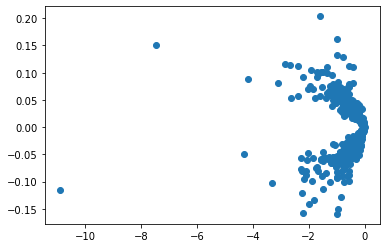

In [614]:
plt.scatter(np.log10(p_tuned), effect_tuned)

### Angle selectivity

In [ ]:
# Angle selectivity
# Calculate selectivity across sessions, in all neurons (not only angle-tuned or touch response neurons because they change)



# Neural Stretching
- Using PCA, per volume
- Plot variance explained vs dimensions across sessions
- Show mean PCA track across sessions
- Calculate distance between trials with 45 pole and 135 pole
- Only regular training sessions, removing test sessions and distractor sessions

In [9]:
# Test in one mouse
emi = 2
mouse = mice[emi]
exp_session = exp_sessions[emi]
volume = 1 # either 0 or 1



if volume==0:
    planes = range(1,5)
else:
    planes = range(5,9)

# Collect responses
total_num_rois = 0
for plane in planes:
    load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
    tr_crude = pd.read_pickle(save_dir / load_fn)
    tr_crude = tr_crude[tr_crude.session < exp_session]
    if plane in [1,5]: # first plane
        pre_pole_volume = np.concatenate(tr_crude.pre_pole_activity.values)
        pre_answer_volume = np.concatenate(tr_crude.pre_answer_response.values)
        post_answer_volume = np.concatenate(tr_crude.pre_answer_response.values)
        post_pole_volume = np.concatenate(tr_crude.post_pole_activity.values)
        touch_trials_volume = np.concatenate(tr_crude.num_touch_pre_answer.apply(lambda x: np.isfinite(x)).values)
        trials_45_volume = np.concatenate(tr_crude.angle.apply(lambda x: x==45).values)
        trials_135_volume = np.concatenate(tr_crude.angle.apply(lambda x: x==135).values)
        trials_correct_volume = np.concatenate(tr_crude.correct.values)
    else:
        pre_pole_volume = np.hstack((pre_pole_volume, np.concatenate(tr_crude.pre_pole_activity.values)))
        pre_answer_volume = np.hstack((pre_answer_volume, np.concatenate(tr_crude.pre_answer_response.values)))
        post_answer_volume = np.hstack((post_answer_volume, np.concatenate(tr_crude.pre_answer_response.values)))
        post_pole_volume = np.hstack((post_pole_volume, np.concatenate(tr_crude.post_pole_activity.values)))
        touch_trials_volume = np.hstack((touch_trials_volume, np.concatenate(tr_crude.num_touch_pre_answer.apply(lambda x: np.isfinite(x)).values)))
        trials_45_volume = np.hstack((trials_45_volume, np.concatenate(tr_crude.angle.apply(lambda x: x==45).values)))
        trials_135_volume = np.hstack((trials_135_volume, np.concatenate(tr_crude.angle.apply(lambda x: x==135).values)))
        trials_correct_volume = np.hstack((trials_correct_volume, np.concatenate(tr_crude.correct.values)))
    total_num_rois += tr_crude.iloc[0].num_roi
num_trials = tr_crude.angle.apply(lambda x: len(x)).values
assert pre_pole_volume.shape[0] == np.sum(num_trials)
assert pre_pole_volume.shape[1] == total_num_rois
# Divide then into sessions
cum_num_trials_session = [0, *np.cumsum(num_trials)]
session_nums = tr_crude.session.values
num_sessions = len(session_nums)
assert num_sessions == len(num_trials)

# # PCA using all the sessions and all the activities led to very slow cumulative Var Exp
# all_activity_volume = np.vstack((pre_pole_volume, pre_answer_volume, post_answer_volume, post_pole_volume))
# X = all_activity_volume[np.where(np.isfinite(np.mean(all_activity_volume,axis=1)))[0],:]
# scaler = StandardScaler()
# pca = PCA()
# pca.fit(X)

pca_list = []
# for si in range(num_sessions):
for si in [0]:
    session_trials = np.array(range(cum_num_trials_session[si],cum_num_trials_session[si+1]))
    touch_trials = touch_trials_volume[session_trials]
    # X = pre_pole_volume[session_trials[np.where(touch_trials)[0]],:]

    all_activity_session = np.vstack((pre_pole_volume[session_trials], pre_answer_volume[session_trials], post_answer_volume[session_trials], post_pole_volume[session_trials]))
    X = all_activity_session[np.where(np.isfinite(np.mean(all_activity_session,axis=1)))[0],:]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    try:
        pca = PCA(svd_solver='auto')
        pca.fit(X)
    except:
        pca = PCA(svd_solver='full')
        pca.fit(X)
    pca_list.append(pca)
    
# Task performance
correct_rate = tr_crude.correct_rate.values

In [12]:
X.shape

(647, 1081)

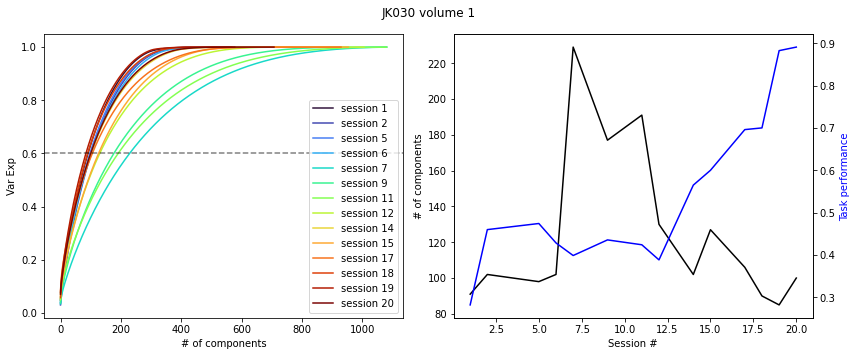

In [721]:
# Variance Explained, across sessions
cmap = mpl.cm.get_cmap('turbo')
var_exp_thresh = 0.6
num_comp_var_exp_60 = np.zeros(num_sessions)
fig, ax = plt.subplots(1,2,figsize=(12,5))
for si in range(num_sessions):
    pca = pca_list[si]
    ax[0].plot(np.cumsum(pca.explained_variance_ratio_), color=cmap(si/(num_sessions-1)), label=f'session {session_nums[si]}')
    num_comp_var_exp_60[si] = np.where(np.cumsum(pca.explained_variance_ratio_) > var_exp_thresh)[0][0]
ax[0].legend()
ax[0].axhline(var_exp_thresh, linestyle='--', color='k', alpha=0.5)
ax[0].set_xlabel('# of components')
ax[0].set_ylabel('Var Exp')
ax[1].plot(session_nums, num_comp_var_exp_60, 'k-')
ax[1].set_ylabel('# of components')
ax[1].set_xlabel('Session #')
ax2 = ax[1].twinx()
ax2.plot(session_nums, correct_rate, 'b-')
ax2.set_ylabel('Task performance', color='b')
fig.suptitle(f'JK{mouse:03d} volume {volume}')
fig.tight_layout()

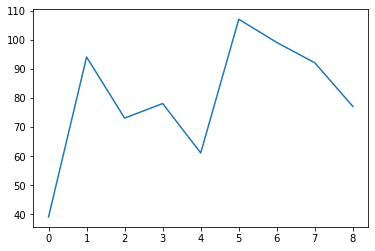

In [673]:
# # of components to explain at least 60% of the variance
var_exp_thresh = 0.6
num_comp_var_exp_60 = np.zeros(num_sessions)
for si in range(num_sessions):
    pca = pca_list[si]
    num_comp_var_exp_60[si] = np.where(np.cumsum(pca.explained_variance_ratio_)>0.6)[0][0]
plt.plot(num_comp_var_exp_60)


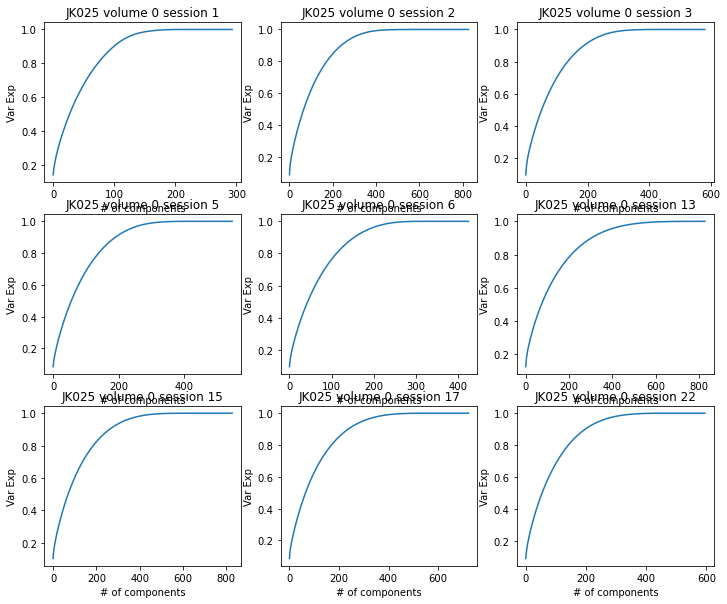

In [667]:
fig, ax = plt.subplots(3,3, figsize=(12,10))
for si in range(num_sessions):
    yi = si // 3
    xi = si % 3
    pca = pca_list[si]
    ax[yi,xi].plot(np.cumsum(pca.explained_variance_ratio_))
    ax[yi,xi].set_xlabel('# of components')
    ax[yi,xi].set_ylabel('Var Exp')
    ax[yi,xi].set_title(f'JK{mouse:03d} volume {volume} session {session_nums[si]}')

Text(0.5, 1.0, 'JK025 volume 0')

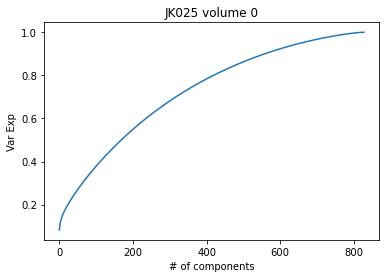

In [660]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel('# of components')
ax.set_ylabel('Var Exp')
ax.set_title(f'JK{mouse:03d} volume {volume}')

### Too many components necessary for Var Exp 60% at the least.
- How about using touch neurons only?